# Data

In [4]:
import csv
import datetime
import glob

import pickle
import scipy.sparse
import time
import zipfile 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

sns.set_style('whitegrid')
sns.set_palette('pastel')
sns.set_context('poster')
#sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')

# Initial code found in https://github.com/eleijonmarck/DDSC/blob/master/src/dsc/dsc.py

## **Import data: REFIT**

In [5]:
with open('data/refit_data_by_category.pk', 'rb') as f:
    data = pickle.load(f)
    
train, test = data['train'], data['test']

# **Algorithms**

In [6]:
from __future__ import division
import numpy as np
import pandas as pd
import time
#import librosa
import pickle
from sklearn.decomposition import SparseCoder,DictionaryLearning, sparse_encode
from sklearn.model_selection import GridSearchCV
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt
import itertools


class DSC():
    def __init__(self, X, general_params, nnsc_params, dd_params, transfer_params=None):
        """
        Args:
            The args are "X, m, T, general_params, nnsc_params, dd_params"
            
            X: training data - List
            #m: number of rows - int
            #T: number of columns (houses) - int
            
            general_params - Dict:
                weeks_to_train - int: number of subsets of data to use, by weekly subset
                rp - float: regularization parameter for SC (and DD) training (sparsity penalty)
                max_iter - int: maximum iter for the SparseCoder function in the Objective function F_obj

            nnsc_params - Dict:
                gradient_step_size (mu) - float: gradient step size for SC
                steps - int: steps for SC training
                epsilon - float: tolerance level for SC training
                n - int: number of hidden components
                
            dd_params - Dict:
                dd_mu - float: gradient step size for DD
                dd_steps - int: steps for DD training
                dd_epsilon - float: tolerance level for DD training
            
            
        """
        self.X = X
        
        self.weeks_to_train = general_params['weeks_to_train']
        self.rp = general_params['rp']
        self.max_iter = general_params['max_iter']
        
        
        self.mu = nnsc_params['gradient_step_size']
        self.steps = nnsc_params['steps']
        self.epsilon = nnsc_params['epsilon']
        self.n = nnsc_params['n_components']
        
        #self.m = m
        #self.T = T
        
        self.dd_steps = dd_params['dd_steps']
        self.dd_epsilon = dd_params['dd_epsilon']
        self.dd_mu = dd_params['dd_mu']

        if transfer_params:
          self.a = transfer_params['a']
          self.b = transfer_params['b']


################################################################
# will initiualize the matrices A,B with positive values and scale
# columns of B s.t b(j) = 1
    def _initialization(self):
      
        a = np.random.random((self.n,self.m))
        b = np.random.random((self.T,self.n))

        # scale columns s.t. b_i^(j) = 1
        b /= sum(b)
        return a,b

    def nnsc_obj_error(self,x, Ap, Bp):
      #print('Ap', Ap)
      #print(np.dot(Bp, Ap))
      return np.linalg.norm(np.dot(Bp, Ap)-x, 2)

    def pre_training(self,x,enable_transfer_learning=False,coral=False):
        # TODO : implement s.t. conditions and frobenius norm to the options
        tic = time.time()
        #the NON NEGATIVE SPARSE CODING (or TSC)
        Ap, Bp ,errors = self.nnsc(enable_transfer_learning,coral)

        tac = time.time()
        t = tac - tic
        print('time of computations for Dictionary Learning with m: {} and T: {} took: {}'.format(self.m,self.T,t))
        return Ap, Bp ,errors
################################################################
    # using only the positive values, this is used for projected gradient descent
    @staticmethod
    def _constraint_for_basis_matrix(a):
        indices = np.where(a < 0.0)
        a[indices] = 0.0
        return a
#################################################################
    def nnsc(self, enable_transfer_learning, coral=False):
        '''
        Method as in NNSC from nonnegative sparse coding from P.Hoyer
        TODO:
        Also create multiple ndarrays that we take the argmin for.
        '''
        errors = []
        # used for F
        A_list = []
        B_list = []
        for ind in range(self.weeks_to_train):

            one_X = self.X.copy()[ind].values
            self.T, self.m = one_X.shape
            Ap, Bp = self._initialization()
            Ap1 = Ap
            Bp1 = Bp
            t = 0
            sparse_matrix_variation = 1

            target_ind = ['target' in x for x in train[0]['X_bar']].index(True)
            if enable_transfer_learning:# or True:
              # Initialize MMD and GL matrices
              S = np.zeros((self.m, self.m))
              N_s, N_t = target_ind, self.m - target_ind
              S[: target_ind, :target_ind] = 1/N_s**2
              S[target_ind:, target_ind:] = 1/N_t**2
              S[target_ind:, :target_ind] = -1/(N_s*N_t)
              S[: target_ind, target_ind:] = -1/(N_s*N_t)
              #print('S', S)
              K = kneighbors_graph(one_X.T, n_neighbors=3).todense()
              L = np.diag(np.sum(K, axis=1))
              L = np.sum(K, axis=1)
              U = K
              for i in range(U.shape[0]):
                U[i, i] = U[i, i] - L[i]

              S_tilde = self.a * S + self.b * U
              S_tilde[S_tilde<0] = 0

            # algo for NNSC

            err_iter = []

            while t <= self.steps and self.epsilon <= sparse_matrix_variation:
                # 2a
                Bp = Bp - self.mu*np.dot((np.dot(Bp,Ap) - one_X),Ap.T)
                # 2b
                Bp = self._constraint_for_basis_matrix(Bp)
                # 2c
                Bp /= sum(Bp)
                # element wise division
                if not enable_transfer_learning: #SC, no transfer
                  dot2 = np.divide(np.dot(Bp.T,one_X),(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp))
                  # 2d
                  Ap = np.multiply(Ap,dot2)
                else: #TSC, transfer using MMD and GL
                  transfer_update = np.dot(Ap, (S_tilde + S_tilde.T)) #Check this

                  if t % (self.steps // 5) == 0:
                    print('\n norms:', np.linalg.norm(transfer_update), np.linalg.norm(Ap), 'rapport ', np.linalg.norm(transfer_update)/np.linalg.norm(Ap))
                    print('MMD term ', np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))), '\n')
                                    
                  dot2 = np.divide(np.dot(Bp.T,one_X),(np.dot(np.dot(Bp.T,Bp),Ap) + self.rp + transfer_update))

                  # 2d
                  Ap = np.multiply(Ap,dot2)

                sparse_matrix_variation = np.linalg.norm(Ap - Ap1)
                basis_matrix_variation = np.linalg.norm(Bp - Bp1)
                Ap1 = Ap
                Bp1 = Bp
                
                #if t%100==0:
                err_iter.append(self.nnsc_obj_error(one_X, Ap, Bp))
                if t%(self.steps//5)==0:
                    print("NNSC variation for A is {} for iter {}, and B variation is {}".format(sparse_matrix_variation,t, basis_matrix_variation))
                if t%(self.steps//50)==0:
                    print("Current objective function value is ", self.nnsc_obj_error(one_X, Ap, Bp))
                    if enable_transfer_learning:# or True:
                      print("Current TSC component value is ", np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))))
                t += 1


            print("\n Last step is {}, NNSC variation for A is {}, and B variation is {} \n".format(t, sparse_matrix_variation, basis_matrix_variation))
            if enable_transfer_learning:# or True:
              print('Final MMD term ', np.trace(np.dot(Ap, np.dot(S_tilde, Ap.T))), '\n')

            errors.append(err_iter)
            A_list.append(Ap)
            B_list.append(Bp)
            
        return A_list, B_list, errors


#################################################################
    def F_obj(self,x,B,x_train=None,A=None,rp_tep=False,rp_gl=False, max_iter=30000):
        '''
        input is lists of the elements
        output list of elements
        '''
        # 4b
        B = np.asarray(B)
        A = np.asarray(A)
        if self.max_iter:
            max_iter = self.max_iter

        acts = sparse_encode(x.T, B.T, algorithm='lasso_cd', alpha=self.rp, positive=True, max_iter=max_iter).T
        acts = self._constraint_for_basis_matrix(acts)
        return acts
#################################################################
    def DD(self,x_bar,B,A):
        '''
        Taking the parameters as x_train_use and discriminate over the
        entire region
        '''
        # 3.
        A_star = np.vstack(A)
        B_cat = np.hstack(B)
        print('A_star has a shape of {}, B_cat has a shape of {}'.format(A_star.shape, B_cat.shape))
        change = 1
        t = 0
        acc_disag = []

        err_disag = []
        print("Initial difference between x_bar and current solution ", 
            np.linalg.norm(x_bar - np.dot(B_cat, A_star)), '\n')
        while t < self.dd_steps and self.dd_epsilon <= change:
            t1=time.time()
            B_cat_p = B_cat
            # 4a
            acts = self.F_obj(x_bar,B_cat,A=A_star)
            t2=time.time()
            # 4b
            B_cat = (B_cat-self.dd_mu*((x_bar-B_cat.dot(acts))
                     .dot(acts.T) - (x_bar-B_cat.dot(A_star)).dot(A_star.T)))
            t3=time.time()
            # 4c
            # scale columns s.t. b_i^(j) = 1
            B_cat = self._constraint_for_basis_matrix(B_cat)
            t4=time.time()
            B_cat /= sum(B_cat)
            acts = self.F_obj(x_bar,B_cat)
            err_disag.append(np.linalg.norm(x_bar - np.dot(B_cat, acts)))
            
            # convergence check
            change = np.linalg.norm(B_cat - B_cat_p)
            
            if t%(self.steps//20)==0:
                print("DD change for B is {} and step is {}".format(change,t))
                print("Norm of A ", np.linalg.norm(acts))
                print("difference between x_bar and current solution", err_disag[-1])
            t += 1

        print('final step is {}, B change is {}, A norm is {}, difference between current_solution and X_bar is {} \n \n'.format(t, change, np.linalg.norm(acts), err_disag[-1]))
        self.acc_ddsc = acc_disag
        self.err_disag = err_disag

        return B_cat, err_disag
 
#################################################################
    def predict(self,A,B):
        x = map(lambda x,y: x.dot(y),B,A)
        return x
#################################################################


# train block for DSC

In [7]:
##REFIT data
general_params = {'weeks_to_train': 35, 'rp': 0.3, 'max_iter': 4000}
nnsc_params = {'gradient_step_size': 10**(-8), 'epsilon': 0.2, 'steps': 4001, 'n_components': 25}
dd_params = {'dd_steps': 30, 'dd_epsilon': 10**(-3), 'dd_mu': 10**(-6)}

transfer_params = {'a': 0.02, 'b': 0.01}

In [8]:
def target_source_split_houses(df, subset='target', split=False, keep_target=False):
  """
  Created to be able to train on differet subsets to compare omitting target from keeping it
  """
  if not split:
    return df
  if keep_target:
    cols_to_extract = [x for x in df.columns if subset in x]
    target_index = ['target' in x for x in df.columns.tolist()].index(True)
    df = df[cols_to_extract]
    return df

  cols_to_extract = [x for x in df.columns if subset not in x]
  df = df[cols_to_extract]  
  return df

In [9]:
weeks_to_train = general_params['weeks_to_train']
weeks_to_test = weeks_to_train
appliance_categories = list(train[0]['X'].keys())

def nnsc_train_block(split, enable_transfer_learning=False, keep_target=False, coral=False):
    res = []
  
    for appliance_category in appliance_categories:
        x_train = [target_source_split_houses(train[week]['X'][appliance_category], split=split, keep_target=keep_target) for week in range(weeks_to_train)]
        x_bar_train = [target_source_split_houses(train[week]['X_bar'], split=split, keep_target=keep_target) for week in range(weeks_to_train)]  
        print('houses that exist in this data', list(x_bar_train[0].columns))

        x_test = [test[week]['X'][appliance_category] for week in range(weeks_to_test)]
        x_bar_test = [test[week]['X_bar'] for week in range(weeks_to_test)]

        train_set = x_train
        test_set = x_test

        # Discriminative Sparse Coding pre_training
        dsc = DSC(train_set, general_params, nnsc_params, dd_params, transfer_params)

        print("started the pre-training for", appliance_category)
        res.append(dsc.pre_training(x_train, enable_transfer_learning, coral))
        print("done pre_training")
        
    A_list = [x[0] for x in res]
    A_list = np.array(A_list)
    B_list = [x[1] for x in res]
    B_list = np.array(B_list)
    errors = [x[2] for x in res]

    return A_list, B_list, errors, dsc

**NNSC on source+target**

In [10]:
t0 = time.time()

A_list, B_list, errors, dsc = nnsc_train_block(split=False)

print('all SC pre-training took {} seconds'.format(round(time.time() - t0, 2)))

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
started the pre-training for fridge
NNSC variation for A is 2410.6752684284597 for iter 0, and B variation is 0.000216987306684591
Current objective function value is  3296.681505943012
Current objective function value is  108.5551528541416
Current objective function value is  37.28838168395424
Current objective function value is  21.222713264373624
Current objective function value is  16.758946502526555
Current objective function value is  14.182297913979538
Current objective function value is  12.412315818759456
Current objective function value is  11.116238803263972
Current objective function value is  10.12911431484038
Current objective function value is  9.346469272229319
NNSC variation for A is 4.896403534869301 for iter 800, and B variation is 0.0001374938376519473
C

Current objective function value is  8.675780288645889
Current objective function value is  8.29245494689845
Current objective function value is  8.091406788111845
Current objective function value is  8.067636340446931
Current objective function value is  8.112526312339789
Current objective function value is  8.172003392137038
Current objective function value is  8.223794656754249
Current objective function value is  8.250281386974214
NNSC variation for A is 3.1042897166067993 for iter 2400, and B variation is 6.724181056120708e-05
Current objective function value is  8.23868521170318
Current objective function value is  8.285773067343374
Current objective function value is  157.04474058429068
Current objective function value is  46.79318473958179
Current objective function value is  10.683627800658341
Current objective function value is  8.070920530715247
Current objective function value is  7.925712338995071
Current objective function value is  7.987254708737351
Current objective fun

Current objective function value is  41.48737912983033
Current objective function value is  43.68832385410844
NNSC variation for A is 182.72153414902263 for iter 4000, and B variation is 0.0064954153718535645
Current objective function value is  43.93431939467827

 Last step is 4002, NNSC variation for A is 182.86478744756243, and B variation is 0.006493778593503115 

NNSC variation for A is 2531.3673581204703 for iter 0, and B variation is 0.00022711810422243822
Current objective function value is  3463.5613553310773
Current objective function value is  285.73291907289314
Current objective function value is  48.15330322883518
Current objective function value is  22.225370046080332
Current objective function value is  15.94826218526549
Current objective function value is  12.792473482482235
Current objective function value is  10.82776003340254
Current objective function value is  9.443251454983258
Current objective function value is  119.17434612513938
Current objective function value

Current objective function value is  43.05315046352856
Current objective function value is  39.7574952635009
Current objective function value is  22.193956433746425
Current objective function value is  46.674089504804556
Current objective function value is  82.51999065740267
Current objective function value is  47.438333733978766
Current objective function value is  41.45152427492921
Current objective function value is  59.83398923806597
Current objective function value is  61.47806921996799
NNSC variation for A is 157.0128196528364 for iter 2400, and B variation is 0.007147831605647423
Current objective function value is  48.75410328595365
Current objective function value is  48.720097997872685
Current objective function value is  55.68376385184098
Current objective function value is  54.091715659795945
Current objective function value is  49.14292654622816
Current objective function value is  49.23107430088953
Current objective function value is  51.42565604269959
Current objective f

Current objective function value is  31.01509634402254
Current objective function value is  30.972831656392643
Current objective function value is  30.63852491267522
NNSC variation for A is 200.37155669077887 for iter 4000, and B variation is 0.004437859896987862
Current objective function value is  30.50667259775364

 Last step is 4002, NNSC variation for A is 200.38726906093433, and B variation is 0.004437865160574907 

NNSC variation for A is 2278.9517820050064 for iter 0, and B variation is 0.00019336267869118207
Current objective function value is  3266.5452803645494
Current objective function value is  109.73764719324092
Current objective function value is  48.44884368551027
Current objective function value is  112.98160935266223
Current objective function value is  87.69826467581399
Current objective function value is  65.31488158883653
Current objective function value is  55.10294164017674
Current objective function value is  50.092456068002015
Current objective function value 

Current objective function value is  6.184891625098915
Current objective function value is  6.192396599574373
Current objective function value is  6.20634520416991
Current objective function value is  6.223208218144812
Current objective function value is  6.239622420471633
Current objective function value is  6.253088803021582
Current objective function value is  6.2612866236438185
NNSC variation for A is 2.303730359867026 for iter 2400, and B variation is 5.35011949793701e-05
Current objective function value is  6.261892177274734
Current objective function value is  6.252950172258984
Current objective function value is  6.232969129955687
Current objective function value is  6.201318376119556
Current objective function value is  6.15793562862755
Current objective function value is  6.104510113496807
Current objective function value is  6.044419041464454
Current objective function value is  5.982989298895743
Current objective function value is  5.927012571954297
Current objective functi

Current objective function value is  6.449745923487138
Current objective function value is  6.4826899221305805
NNSC variation for A is 1.0985627796211708 for iter 4000, and B variation is 3.101158704649291e-05
Current objective function value is  6.515204146328317

 Last step is 4002, NNSC variation for A is 1.0980807081590953, and B variation is 3.1002606421707675e-05 

NNSC variation for A is 1989.302099778141 for iter 0, and B variation is 0.00018134620945445701
Current objective function value is  2827.8293624465227
Current objective function value is  89.12598137323833
Current objective function value is  35.440257298353025
Current objective function value is  21.402340551944693
Current objective function value is  15.381028369371522
Current objective function value is  12.240278000934227
Current objective function value is  10.3364120863169
Current objective function value is  9.002235140763666
Current objective function value is  8.037391919797109
Current objective function valu

Current objective function value is  5.767650393906348
Current objective function value is  5.797067174113733
Current objective function value is  5.825760915657473
Current objective function value is  5.852914153469638
Current objective function value is  5.879173747975478
Current objective function value is  5.904618050009117
Current objective function value is  5.929252253540792
NNSC variation for A is 1.3104836091575682 for iter 2400, and B variation is 3.879748193962128e-05
Current objective function value is  5.952378839089955
Current objective function value is  5.975149257151977
Current objective function value is  5.997306285053878
Current objective function value is  6.018462877797409
Current objective function value is  6.038743437792002
Current objective function value is  6.058666599740501
Current objective function value is  6.078009225405724
Current objective function value is  6.096518501683368
Current objective function value is  6.114750330086935
Current objective fun

Current objective function value is  6.3019335129299385
NNSC variation for A is 0.659767473625885 for iter 4000, and B variation is 2.1429374900260353e-05
Current objective function value is  6.311413804622775

 Last step is 4002, NNSC variation for A is 0.659554327192209, and B variation is 2.1422169786213862e-05 

NNSC variation for A is 2028.917963378548 for iter 0, and B variation is 0.00019257512496462115
Current objective function value is  2951.752956234644
Current objective function value is  95.42980246003471
Current objective function value is  283.0062903362829
Current objective function value is  110.65835883595159
Current objective function value is  83.41855426099757
Current objective function value is  70.45398134967844
Current objective function value is  62.341148962124954
Current objective function value is  56.78256025353494
Current objective function value is  52.17965386888372
Current objective function value is  47.950121648198895
NNSC variation for A is 12.470157

Current objective function value is  5.724590642297656
Current objective function value is  5.749441109105023
Current objective function value is  5.773082857361466
Current objective function value is  5.795733225517545
Current objective function value is  5.81755908379069
NNSC variation for A is 0.5944500666215272 for iter 2400, and B variation is 3.0217967222342558e-05
Current objective function value is  5.838182727406949
Current objective function value is  5.857877681929953
Current objective function value is  5.875754016490218
Current objective function value is  5.892878049000502
Current objective function value is  5.90945422795938
Current objective function value is  5.925508256137225
Current objective function value is  5.941093875317115
Current objective function value is  5.956253518577281
Current objective function value is  5.971016720408152
Current objective function value is  5.985404775772075
NNSC variation for A is 0.41185703955605757 for iter 3200, and B variation is

Current objective function value is  6.014485161478347
NNSC variation for A is 0.7589870474204735 for iter 4000, and B variation is 1.8676234777042427e-05
Current objective function value is  6.019066620103091

 Last step is 4002, NNSC variation for A is 0.7588063800923078, and B variation is 1.8675458404465723e-05 

NNSC variation for A is 1668.9544582726724 for iter 0, and B variation is 0.00015566749115788247
Current objective function value is  2645.1368217855297
Current objective function value is  135.39543761829208
Current objective function value is  29.168632522869952
Current objective function value is  19.61838003852907
Current objective function value is  15.690612633046626
Current objective function value is  13.140936716598198
Current objective function value is  11.260695791592392
Current objective function value is  9.798737382880596
Current objective function value is  8.652845588907667
Current objective function value is  7.913665611125495
NNSC variation for A is 1.95

Current objective function value is  5.907294197295138
Current objective function value is  5.874526869644134
Current objective function value is  5.86131543407395
Current objective function value is  5.861030534816439
Current objective function value is  5.8681397088247556
Current objective function value is  5.879289168477417
NNSC variation for A is 0.9180819645833108 for iter 2400, and B variation is 4.8139300735740545e-05
Current objective function value is  5.8927123822195835
Current objective function value is  5.907283523393222
Current objective function value is  5.922425927721116
Current objective function value is  5.937649376072665
Current objective function value is  5.9528851249138155
Current objective function value is  5.968024391790383
Current objective function value is  5.983049499560786
Current objective function value is  5.9965357665201875
Current objective function value is  6.009207386714183
Current objective function value is  6.021819691843482
NNSC variation fo

NNSC variation for A is 19.389159467640162 for iter 4000, and B variation is 0.0017452954993016057
Current objective function value is  12.83847078227052

 Last step is 4002, NNSC variation for A is 19.370420851319864, and B variation is 0.0017446612998700567 

NNSC variation for A is 1939.196542039198 for iter 0, and B variation is 0.00018922562911386447
Current objective function value is  2839.4078988014758
Current objective function value is  61.92648005880809
Current objective function value is  26.329392613844966
Current objective function value is  17.7823339734026
Current objective function value is  13.913794059617675
Current objective function value is  11.709859058023644
Current objective function value is  10.294092629100012
Current objective function value is  9.306818111299759
Current objective function value is  8.725717353183098
Current objective function value is  8.494899015397445
NNSC variation for A is 3.4048855030070504 for iter 800, and B variation is 0.0001130139

Current objective function value is  7.925598366395453
Current objective function value is  7.859273898715555
Current objective function value is  7.780466220949757
Current objective function value is  7.69224985512972
NNSC variation for A is 2.2104440609248868 for iter 2400, and B variation is 5.8240946617774236e-05
Current objective function value is  7.59630166603821
Current objective function value is  7.48933241521354
Current objective function value is  7.369306791069195
Current objective function value is  7.232362172730762
Current objective function value is  7.077273141698349
Current objective function value is  6.905548465727228
Current objective function value is  6.725037886302927
Current objective function value is  6.580092136193276
Current objective function value is  6.528652082976906
Current objective function value is  6.513217912789932
NNSC variation for A is 1.5178422350917236 for iter 3200, and B variation is 5.0683744162791585e-05
Current objective function value 

Current objective function value is  328.99701981220716
Current objective function value is  327.6134904551932
Current objective function value is  326.09265551512885
Current objective function value is  324.43724521480794
Current objective function value is  322.6528190403718
Current objective function value is  320.7468628241141
Current objective function value is  318.72935571759405
Current objective function value is  316.61647485317144
NNSC variation for A is 1.1887247368753675 for iter 800, and B variation is 0.00029613723199869275
Current objective function value is  314.42563834549935
Current objective function value is  312.1719251941129
Current objective function value is  309.8737508829822
Current objective function value is  307.5480356093053
Current objective function value is  305.20688426950596
Current objective function value is  303.0142762721684
Current objective function value is  301.0538103866621
Current objective function value is  299.4982581377719
Current object

Current objective function value is  194.30246571281793
Current objective function value is  100.92390718678244
Current objective function value is  72.04600245540466
Current objective function value is  72.04594700416253
Current objective function value is  72.04592630084223

 Last step is 690, NNSC variation for A is 0.19940940199097132, and B variation is 7.845722295046955e-05 

NNSC variation for A is 1768.4078303684435 for iter 0, and B variation is 0.0004179457757791391
Current objective function value is  6605.257367253853
Current objective function value is  299.28884115695814
Current objective function value is  299.288784816643
Current objective function value is  299.288771794211
Current objective function value is  299.2887664135998
Current objective function value is  299.2887652612079
Current objective function value is  299.28876531400795
Current objective function value is  299.2887620238963
Current objective function value is  299.2887596079254
Current objective functi

NNSC variation for A is 1.1547219392893595 for iter 2400, and B variation is 0.00012575904446989099
Current objective function value is  257.8505670123778
Current objective function value is  257.5536546903157
Current objective function value is  257.2682583086836
Current objective function value is  256.9929377767669
Current objective function value is  256.7247728693056
Current objective function value is  256.46143035284143
Current objective function value is  256.2006248240753
Current objective function value is  255.9400535954676
Current objective function value is  255.67733555390345
Current objective function value is  255.40993671482346
NNSC variation for A is 1.174250292362929 for iter 3200, and B variation is 9.883513272210024e-05
Current objective function value is  255.1350749543936
Current objective function value is  254.84962811931055
Current objective function value is  254.54999366595294
Current objective function value is  254.2319064106741
Current objective function 

Current objective function value is  357.53524009308825
Current objective function value is  357.5353085884125
Current objective function value is  357.53537332552673
Current objective function value is  357.53543459679867
Current objective function value is  357.53549266581706
NNSC variation for A is 1.5497543150417301 for iter 2400, and B variation is 0.00011989442281241731
Current objective function value is  357.53554777075914
Current objective function value is  357.53560012730736
Current objective function value is  357.535649931183
Current objective function value is  357.5356973603556
Current objective function value is  357.5357425769664
Current objective function value is  357.5357857290188
Current objective function value is  357.53582695185315
Current objective function value is  357.53586636945215
Current objective function value is  357.535904095585
Current objective function value is  357.5359402348201
NNSC variation for A is 1.6881924096729426 for iter 3200, and B varia

Current objective function value is  2295.867809033299
Current objective function value is  2295.867826199002
NNSC variation for A is 126.1375781536607 for iter 1600, and B variation is 0.05112411341062342
Current objective function value is  2295.867836746706
Current objective function value is  2295.8678432924235
Current objective function value is  2295.8678483505682
Current objective function value is  2295.867853381085
Current objective function value is  2295.867858857908
Current objective function value is  2295.8678647363904
Current objective function value is  2295.8678707302
Current objective function value is  2295.867876541117
Current objective function value is  2295.8678820434957
Current objective function value is  2295.867887264322
NNSC variation for A is 81.8278716313174 for iter 2400, and B variation is 0.029638887612130033
Current objective function value is  2295.8678922896725
Current objective function value is  2295.867897198034
Current objective function value is

Current objective function value is  174.0877827383298
Current objective function value is  174.08778273811035
Current objective function value is  174.08778273790563
NNSC variation for A is 47.320867932372416 for iter 3200, and B variation is 0.008944252484117262
Current objective function value is  174.08778273771523
Current objective function value is  174.08778273753862
Current objective function value is  174.0877827373754
Current objective function value is  174.08778273722515
Current objective function value is  174.08778273708688
Current objective function value is  174.08778273696
Current objective function value is  174.0877827368436
Current objective function value is  174.08778273673656
Current objective function value is  174.08778273663785
Current objective function value is  174.0877827365464
NNSC variation for A is 41.613294034626264 for iter 4000, and B variation is 0.007767690207059692
Current objective function value is  174.08778273646152

 Last step is 4002, NNSC v

Current objective function value is  700.4850681964724
Current objective function value is  700.3231447944736
Current objective function value is  700.1618854787894
Current objective function value is  699.9956960270955
NNSC variation for A is 28.199255525561743 for iter 800, and B variation is 0.016014173085966473
Current objective function value is  699.8215048624165
Current objective function value is  699.6387880298596
Current objective function value is  699.4466645910231
Current objective function value is  699.2435830333253
Current objective function value is  699.0288682717186
Current objective function value is  698.8015540795376
Current objective function value is  698.5605260032918
Current objective function value is  698.4402682981619
Current objective function value is  698.3411501312293
Current objective function value is  698.2367296526437
NNSC variation for A is 28.383630655587584 for iter 1600, and B variation is 0.006689255008192742
Current objective function value is

Current objective function value is  4365.518848958998
Current objective function value is  4365.355812150223
Current objective function value is  4365.210599162959
Current objective function value is  4365.082071837672
NNSC variation for A is 1909.9783005366155 for iter 2400, and B variation is 0.6686481589237465
Current objective function value is  4364.964025584378
Current objective function value is  4364.816226832967
Current objective function value is  4364.482113700162
Current objective function value is  4364.04776111881
Current objective function value is  4363.747573779127
Current objective function value is  4363.556246702435
Current objective function value is  4363.408874409695
Current objective function value is  4363.26940238417
Current objective function value is  4363.12061940221
Current objective function value is  4362.941032153471
NNSC variation for A is 1917.2426706770614 for iter 3200, and B variation is 0.6685430051634199
Current objective function value is  4362

Current objective function value is  437.8310881076196
Current objective function value is  437.47360274086856
Current objective function value is  437.0723489799918
Current objective function value is  436.62067371209133
Current objective function value is  436.1085498312734
NNSC variation for A is 169.62851115906125 for iter 4000, and B variation is 0.03962803884589273
Current objective function value is  435.5195044589673

 Last step is 4002, NNSC variation for A is 169.98443583243525, and B variation is 0.03964304602793968 

NNSC variation for A is 3085.078423248184 for iter 0, and B variation is 0.0006055755857385559
Current objective function value is  12726.202924484718
Current objective function value is  3312.8579180756997
Current objective function value is  3232.8439365874747
Current objective function value is  3091.5791675159307
Current objective function value is  3225.4316725458775
Current objective function value is  3252.6850581221847
Current objective function value i

Current objective function value is  1174.7016582364695
Current objective function value is  1173.5457354465761
Current objective function value is  1172.2123894296722
Current objective function value is  1170.6494155714956
NNSC variation for A is 181.56482085259844 for iter 1600, and B variation is 0.16285881427514526
Current objective function value is  1168.807399402593
Current objective function value is  1166.626453125703
Current objective function value is  1163.9927472661377
Current objective function value is  1160.8368180147515
Current objective function value is  1156.9926833803102
Current objective function value is  1152.0852264412224
Current objective function value is  1145.9103251439435
Current objective function value is  1137.554164848631
Current objective function value is  1125.4919803233647
Current objective function value is  1107.0377908133971
NNSC variation for A is 211.92722671812322 for iter 2400, and B variation is 0.15087635126958798
Current objective functio

Current objective function value is  2166.6569626148594
Current objective function value is  2155.854165334398
Current objective function value is  2161.917229831576
Current objective function value is  2153.219325907776
Current objective function value is  2120.500073163236
NNSC variation for A is 596.9080230217079 for iter 3200, and B variation is 0.27521863481529
Current objective function value is  1913.8949866281089
Current objective function value is  1704.847682991257
Current objective function value is  1699.7752442287804
Current objective function value is  1699.6857853741633
Current objective function value is  1699.8698389262026
Current objective function value is  1700.101703813773
Current objective function value is  1700.3894570293332
Current objective function value is  1700.7354273868948
Current objective function value is  1701.106126595971
Current objective function value is  1701.4917765526968
NNSC variation for A is 281.14791897100184 for iter 4000, and B variation 

Current objective function value is  1207.052449258267
Current objective function value is  1206.0906831259465
Current objective function value is  1205.0466314858156
Current objective function value is  1203.9096275802108
Current objective function value is  1202.6626984512773
Current objective function value is  1201.2981454224466
Current objective function value is  1199.8072547924753
Current objective function value is  1198.1570529805338
Current objective function value is  1196.321917137029
NNSC variation for A is 438.50784676948837 for iter 3200, and B variation is 0.16786499405459543
Current objective function value is  1194.2686587969529
Current objective function value is  1191.950119373847
Current objective function value is  1189.31173359152
Current objective function value is  1186.2899528204418
Current objective function value is  1182.8018892266448
Current objective function value is  1178.7588084520355
Current objective function value is  1174.1073179424304
Current obje

Current objective function value is  6.770982137363003
Current objective function value is  6.733928024960285
Current objective function value is  6.747856385059993
Current objective function value is  6.77226520529607
Current objective function value is  6.800235706900388
Current objective function value is  6.828718195683957
Current objective function value is  6.855963677182255
Current objective function value is  6.8811178311557235
Current objective function value is  6.903554311464009
NNSC variation for A is 1.7599024152872602 for iter 1600, and B variation is 5.415979243926454e-05
Current objective function value is  6.922649430830656
Current objective function value is  6.937764730097337
Current objective function value is  6.948622860683535
Current objective function value is  6.955459951252226
Current objective function value is  6.959519186517749
Current objective function value is  6.959962457381528
Current objective function value is  6.960929389342049
Current objective fun

Current objective function value is  7.208175968436729
Current objective function value is  7.207179624504244
Current objective function value is  7.206444239980473
Current objective function value is  7.205939804635545
Current objective function value is  7.205639727668569
Current objective function value is  7.205520423207665
NNSC variation for A is 0.927177715144677 for iter 4000, and B variation is 2.0277135090647845e-05
Current objective function value is  7.205552653960899

 Last step is 4002, NNSC variation for A is 0.9268506489083833, and B variation is 2.0269121465730403e-05 

NNSC variation for A is 1366.7376146111746 for iter 0, and B variation is 0.00012370054602285735
Current objective function value is  2044.7057259805747
Current objective function value is  132.4245584403923
Current objective function value is  117.1767872753866
Current objective function value is  108.13609744048618
Current objective function value is  77.06284538779809
Current objective function value 

Current objective function value is  11.757332799886397
Current objective function value is  11.376980219855186
Current objective function value is  11.05279575597462
NNSC variation for A is 3.145084450184095 for iter 2400, and B variation is 4.372758573546965e-05
Current objective function value is  10.774641452030673
Current objective function value is  10.53457402269483
Current objective function value is  10.326083080566097
Current objective function value is  10.144140071879058
Current objective function value is  9.984505715969657
Current objective function value is  9.845086840214906
Current objective function value is  9.723536860874185
Current objective function value is  9.615835612118081
Current objective function value is  9.519778765470274
Current objective function value is  9.433540917780796
NNSC variation for A is 2.3702819573608283 for iter 3200, and B variation is 2.786444347097823e-05
Current objective function value is  9.357449304150398
Current objective function v

Current objective function value is  20.477519286835534
Current objective function value is  17.020112709843318
NNSC variation for A is 3.337189485811073 for iter 800, and B variation is 0.00015280226467356353
Current objective function value is  14.525593252443944
Current objective function value is  12.696546747381948
Current objective function value is  11.346093654183
Current objective function value is  10.34758423420976
Current objective function value is  9.609554993606416
Current objective function value is  9.062115582235908
Current objective function value is  8.652336897505268
Current objective function value is  8.341147896877644
Current objective function value is  8.100516774321157
Current objective function value is  7.910783286657019
NNSC variation for A is 2.482634559266282 for iter 1600, and B variation is 5.931438094087891e-05
Current objective function value is  7.7582612691408395
Current objective function value is  7.633677274362687
Current objective function valu

NNSC variation for A is 0.949064091070817 for iter 3200, and B variation is 1.6717992140909744e-05
Current objective function value is  6.2771449875598
Current objective function value is  6.282396420661211
Current objective function value is  6.287500707369839
Current objective function value is  6.292456450625919
Current objective function value is  6.297264266376897
Current objective function value is  6.301925396690731
Current objective function value is  6.306442510974609
Current objective function value is  6.310818952114449
Current objective function value is  6.315058418256958
Current objective function value is  6.319164942856821
NNSC variation for A is 0.7636579933618783 for iter 4000, and B variation is 1.2642372153334935e-05
Current objective function value is  6.323142770295936

 Last step is 4002, NNSC variation for A is 0.7634508938355214, and B variation is 1.2638471167414575e-05 

NNSC variation for A is 1204.9221855040923 for iter 0, and B variation is 0.0001190429134

Current objective function value is  6.359156350123093
Current objective function value is  6.346859323453275
Current objective function value is  6.340963604827444
Current objective function value is  6.3397910053828275
Current objective function value is  6.342083978720261
Current objective function value is  6.346914014192361
Current objective function value is  6.353553606910789
Current objective function value is  6.361442481094382
Current objective function value is  6.370148828007626
NNSC variation for A is 0.7341646256750978 for iter 2400, and B variation is 3.144402009825192e-05
Current objective function value is  6.379339923163141
Current objective function value is  6.388760166066364
Current objective function value is  6.398214432041637
Current objective function value is  6.407555274467433
Current objective function value is  6.416672970321351
Current objective function value is  6.425487701198563
Current objective function value is  6.433943362028955
Current objective fu

NNSC variation for A is 0.5842801341647401 for iter 4000, and B variation is 2.1763002450174783e-05
Current objective function value is  6.890329585005155

 Last step is 4002, NNSC variation for A is 0.5838884729093714, and B variation is 2.1758552829170206e-05 

NNSC variation for A is 976.3884421040149 for iter 0, and B variation is 0.00012191690196410139
Current objective function value is  1767.0444044611831
Current objective function value is  133.91686064765267
Current objective function value is  89.9618787498625
Current objective function value is  56.13654848164398
Current objective function value is  39.316447663157106
Current objective function value is  29.579614819527944
Current objective function value is  23.308784209589003
Current objective function value is  18.987227202144766
Current objective function value is  15.870367926518812
Current objective function value is  13.553435995336919
NNSC variation for A is 2.0201999472741377 for iter 800, and B variation is 0.00012

Current objective function value is  7.500836566141446
Current objective function value is  7.500176295656169
Current objective function value is  7.499818928703018
Current objective function value is  7.4996072965831555
Current objective function value is  7.499651882823154
Current objective function value is  7.499934243896243
Current objective function value is  7.5004456842897085
Current objective function value is  7.501191936295871
NNSC variation for A is 1.4510005591694728 for iter 3200, and B variation is 2.2767172958370263e-05
Current objective function value is  7.502111416872128
Current objective function value is  7.503156571493384
Current objective function value is  7.504343146398813
Current objective function value is  7.505649595727553
Current objective function value is  7.50703758450721
Current objective function value is  7.508437177143402
Current objective function value is  7.509764397095027
Current objective function value is  7.510943407894481
Current objective f

Current objective function value is  6.287512957250036
Current objective function value is  6.302311711774695
Current objective function value is  6.317550756853753
Current objective function value is  6.333427165961206
Current objective function value is  6.3492322278560795
Current objective function value is  6.364622131005078
Current objective function value is  6.379577824754915
NNSC variation for A is 0.9093448702091407 for iter 1600, and B variation is 2.596950976108625e-05
Current objective function value is  6.394056188228601
Current objective function value is  6.407983388560781
Current objective function value is  6.421317833308123
Current objective function value is  6.4340733071296965
Current objective function value is  6.446258894829246
Current objective function value is  6.457887732513612
Current objective function value is  6.468960475455871
Current objective function value is  6.479503350712656
Current objective function value is  6.489557047641611
Current objective f

Current objective function value is  7.081290657301033
Current objective function value is  7.04530567531891
Current objective function value is  7.012206947406973
Current objective function value is  6.981750638571848
NNSC variation for A is 0.7022635713443683 for iter 4000, and B variation is 2.980490369993925e-05
Current objective function value is  6.953708195795079

 Last step is 4002, NNSC variation for A is 0.7021797577055402, and B variation is 2.979282993235596e-05 

NNSC variation for A is 960.1982925441771 for iter 0, and B variation is 0.00010994433339500311
Current objective function value is  1796.974846683813
Current objective function value is  182.02143224152402
Current objective function value is  84.71642740291021
Current objective function value is  61.216770255445724
Current objective function value is  47.08827259953764
Current objective function value is  37.656271839956695
Current objective function value is  30.073087504718334
Current objective function value i

Current objective function value is  6.168065907092758
Current objective function value is  6.177524561190953
NNSC variation for A is 0.7180982079545937 for iter 2400, and B variation is 2.4643476539187313e-05
Current objective function value is  6.18669492543773
Current objective function value is  6.195588715570962
Current objective function value is  6.2042188503566
Current objective function value is  6.212599436020823
Current objective function value is  6.220741929230644
Current objective function value is  6.228643796697321
Current objective function value is  6.236342811988742
Current objective function value is  6.243846375724787
Current objective function value is  6.251175057115036
Current objective function value is  6.258348529041067
NNSC variation for A is 0.5172704842596502 for iter 3200, and B variation is 1.7820399937154905e-05
Current objective function value is  6.2653744825677675
Current objective function value is  6.272259658399445
Current objective function value

Current objective function value is  6.271644774982993
Current objective function value is  6.268211465175402
NNSC variation for A is 1.040612774485263 for iter 1600, and B variation is 4.273551390818195e-05
Current objective function value is  6.26635808191013
Current objective function value is  6.265753352541815
Current objective function value is  6.2659632429205425
Current objective function value is  6.266774351479912
Current objective function value is  6.268038497245378
Current objective function value is  6.2696074757909495
Current objective function value is  6.271368627907579
Current objective function value is  6.273254636737281
Current objective function value is  6.2752287343568
Current objective function value is  6.277221782649214
NNSC variation for A is 0.5890716238442143 for iter 2400, and B variation is 2.6096846281877094e-05
Current objective function value is  6.27921254650025
Current objective function value is  6.281185416118897
Current objective function value i

Current objective function value is  5.962030656957421
Current objective function value is  5.966949610670544
NNSC variation for A is 0.37258185734024724 for iter 4000, and B variation is 2.40744174271719e-05
Current objective function value is  5.972732504087455

 Last step is 4002, NNSC variation for A is 0.3724609137063502, and B variation is 2.407355489432855e-05 

NNSC variation for A is 1046.282355652398 for iter 0, and B variation is 0.00011906904064931064
Current objective function value is  1735.5137547894703
Current objective function value is  186.22637794334761
Current objective function value is  76.89972376517255
Current objective function value is  45.65155228724375
Current objective function value is  33.3055337906657
Current objective function value is  25.816261755734775
Current objective function value is  20.7778215341651
Current objective function value is  17.20380909385972
Current objective function value is  14.585421904184765
Current objective function value is

Current objective function value is  93.29583982604794
Current objective function value is  55.4652888030673
Current objective function value is  36.1092232561208
Current objective function value is  29.43557152728057
Current objective function value is  28.366487637618405
Current objective function value is  28.070056587327883
Current objective function value is  27.90992318651203
NNSC variation for A is 0.24002617219631728 for iter 800, and B variation is 0.00011016865401180327
Current objective function value is  27.79470825207934
Current objective function value is  27.698075655163112

 Last step is 882, NNSC variation for A is 0.19998883866322745, and B variation is 8.686800577662588e-05 

NNSC variation for A is 888.9412693021795 for iter 0, and B variation is 0.0002841644305074085
Current objective function value is  5873.190517421351
Current objective function value is  155.11554994780204
Current objective function value is  89.82233116827436
Current objective function value is

Current objective function value is  194.5242891332284
Current objective function value is  74.53900710619898
Current objective function value is  56.0586418283751
Current objective function value is  46.46588811947114
Current objective function value is  40.11050272775966
Current objective function value is  35.50260820382674
Current objective function value is  31.96209932851486
Current objective function value is  29.13133774299495
Current objective function value is  26.80865407288499
NNSC variation for A is 0.23788185404647746 for iter 800, and B variation is 9.858177400835337e-05
Current objective function value is  24.86941959342084
Current objective function value is  23.215319764729696

 Last step is 933, NNSC variation for A is 0.19989852357363563, and B variation is 8.514450111495724e-05 

NNSC variation for A is 1207.301685742565 for iter 0, and B variation is 0.000308363294350142
Current objective function value is  8100.212145999108
Current objective function value is  13


 Last step is 779, NNSC variation for A is 0.19943586042511693, and B variation is 5.6668301010153794e-05 

NNSC variation for A is 898.50338054835 for iter 0, and B variation is 0.00026297440260921243
Current objective function value is  5090.70035977934
Current objective function value is  110.3625420575681
Current objective function value is  61.60235095859184
Current objective function value is  45.641836003560336
Current objective function value is  36.83951848191124
Current objective function value is  31.16192486441976
Current objective function value is  27.182829450500687
Current objective function value is  24.23461415228593
Current objective function value is  21.958668853209147
Current objective function value is  20.1540198400687
NNSC variation for A is 0.23031764213146547 for iter 800, and B variation is 6.73904307108492e-05
Current objective function value is  18.700213380769185
Current objective function value is  17.516933406595065

 Last step is 883, NNSC variation f

Current objective function value is  45.750449007611145
Current objective function value is  45.70377310044345

 Last step is 747, NNSC variation for A is 0.19983350182046772, and B variation is 0.00012904120621838488 

NNSC variation for A is 1276.3900558263217 for iter 0, and B variation is 0.0003343548229054411
Current objective function value is  7325.75453309096
Current objective function value is  179.9020673733202
Current objective function value is  166.70367064833928
Current objective function value is  134.18495669639972
Current objective function value is  97.14526931888486
Current objective function value is  71.03818951879103
Current objective function value is  54.32729963147815
Current objective function value is  44.352250474229805
Current objective function value is  43.19562448680145
Current objective function value is  43.09445113296258
NNSC variation for A is 0.2492435857975784 for iter 800, and B variation is 0.0002310609535709667
Current objective function value i

**NNSC on source, DD on target**

In [11]:
t0 = time.time()

A_list_source_only, B_list_source_only, errors_source_only, dsc_source_only = nnsc_train_block(split=True, keep_target=False)

print('all SC pre-training took {} seconds'.format(round(time.time() - t0, 2)))

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9']
started the pre-training for fridge
NNSC variation for A is 1841.3603992430008 for iter 0, and B variation is 0.00014028074710314072
Current objective function value is  2643.0263978507364
Current objective function value is  62.16366313894458
Current objective function value is  32.02253441119484
Current objective function value is  22.327602085659322
Current objective function value is  17.130231882744706
Current objective function value is  14.001779057426225
Current objective function value is  11.913971602574666
Current objective function value is  10.445942617908392
Current objective function value is  9.4004347931506
Current objective function value is  8.680257070212608
NNSC variation for A is 3.342301112479187 for iter 800, and B variation is 0.00013213096781278632
Current objective function value is  8.188186905068491
Current objective function value is  

Current objective function value is  5.369072965019629
Current objective function value is  5.300938298728708
Current objective function value is  5.28734540933795
Current objective function value is  5.297322693578438
NNSC variation for A is 2.0833033890164856 for iter 2400, and B variation is 4.829761939983923e-05
Current objective function value is  5.315905392895901
Current objective function value is  5.337872760000349
Current objective function value is  5.360985703473168
Current objective function value is  5.3844837759155055
Current objective function value is  5.407968122961419
Current objective function value is  5.431568374085875
Current objective function value is  5.455417642177568
Current objective function value is  5.479485682184902
Current objective function value is  5.503981763429179
Current objective function value is  5.529282687567453
NNSC variation for A is 1.5861954684325192 for iter 3200, and B variation is 3.603791615958499e-05
Current objective function value

Current objective function value is  28.917421791308186
Current objective function value is  20.317836740828565
Current objective function value is  16.02180942918494
Current objective function value is  13.40929301036453
Current objective function value is  11.620261331134124
Current objective function value is  10.290695558672036
Current objective function value is  9.245105168000334
Current objective function value is  8.388480563793609
NNSC variation for A is 2.893483954299774 for iter 800, and B variation is 0.00011828468620490583
Current objective function value is  7.665869536186045
Current objective function value is  7.047597083153719
Current objective function value is  6.512884066131887
Current objective function value is  6.04702643526864
Current objective function value is  5.639976588279687
Current objective function value is  5.288928286977664
Current objective function value is  5.204816295889897
Current objective function value is  5.284158857034126
Current objective f

Current objective function value is  7.3873269300341535
Current objective function value is  7.352346244485474
NNSC variation for A is 1.6199882522194218 for iter 2400, and B variation is 4.23586402092931e-05
Current objective function value is  7.314426165005157
Current objective function value is  7.273582987366659
Current objective function value is  7.230246969661739
Current objective function value is  7.185198582021209
Current objective function value is  7.139514034880982
Current objective function value is  7.0942272803290995
Current objective function value is  7.050817843592914
Current objective function value is  7.010310590990013
Current objective function value is  6.97352278237188
Current objective function value is  6.941883154589996
NNSC variation for A is 1.0537998510015145 for iter 3200, and B variation is 2.8496988174344658e-05
Current objective function value is  6.915813836621736
Current objective function value is  6.894849907460455
Current objective function valu

Current objective function value is  16.99792700494882
Current objective function value is  14.7081298162037
Current objective function value is  13.242714705798353
Current objective function value is  12.230460100722771
Current objective function value is  11.491947372572342
Current objective function value is  10.908775171558299
NNSC variation for A is 4.8175322747948615 for iter 800, and B variation is 0.00013769877259687199
Current objective function value is  10.426513268747662
Current objective function value is  10.016890428466379
Current objective function value is  9.66523138843054
Current objective function value is  9.354078806794387
Current objective function value is  9.070356930026053
Current objective function value is  8.80961429591298
Current objective function value is  8.565345592787192
Current objective function value is  8.331067574444246
Current objective function value is  8.102298317098963
Current objective function value is  7.876296942461649
NNSC variation for

NNSC variation for A is 1.1438039809429885 for iter 2400, and B variation is 4.860924678552249e-05
Current objective function value is  4.679229798132593
Current objective function value is  4.695786161274979
Current objective function value is  4.722904910376669
Current objective function value is  4.751458091979184
Current objective function value is  4.778261757123106
Current objective function value is  4.804163888963837
Current objective function value is  4.830597263290895
Current objective function value is  4.85888587874097
Current objective function value is  4.887933071087119
Current objective function value is  4.918306196973794
NNSC variation for A is 0.7421297795557283 for iter 3200, and B variation is 3.881138170131121e-05
Current objective function value is  4.950499879572528
Current objective function value is  4.980386418396243
Current objective function value is  5.000978744323203
Current objective function value is  5.017480607578675
Current objective function value 

Current objective function value is  9.72037504917101
Current objective function value is  8.595126866019411
Current objective function value is  7.7976290346580885
Current objective function value is  7.2236743728290955
NNSC variation for A is 2.8218562647081495 for iter 800, and B variation is 9.656588493985494e-05
Current objective function value is  6.812066290780091
Current objective function value is  6.513689748375344
Current objective function value is  6.296124317121979
Current objective function value is  6.129501201967482
Current objective function value is  5.990097082237132
Current objective function value is  5.865761030155042
Current objective function value is  5.750676502440616
Current objective function value is  5.642336146221362
Current objective function value is  5.5413142800989235
Current objective function value is  5.451447975960331
NNSC variation for A is 1.6942130554833927 for iter 1600, and B variation is 6.355569297969615e-05
Current objective function valu

Current objective function value is  48.56383277456652
Current objective function value is  24.069557761527705
Current objective function value is  16.589363772375645
Current objective function value is  13.118470397154482
Current objective function value is  11.1207808077387
Current objective function value is  9.81421405236232
Current objective function value is  8.866637781276914
Current objective function value is  8.129321875199437
Current objective function value is  7.516650716585236
NNSC variation for A is 1.1360352761976167 for iter 800, and B variation is 9.510014322383876e-05
Current objective function value is  6.989885351581234
Current objective function value is  6.53113313141029
Current objective function value is  6.1246858648953095
Current objective function value is  5.764459755353135
Current objective function value is  5.4455587786584685
Current objective function value is  5.164264845457582
Current objective function value is  4.918864708869736
Current objective fu

Current objective function value is  5.127379068937451
Current objective function value is  5.143156877530081
Current objective function value is  5.159910257823926
Current objective function value is  5.177375647613223
Current objective function value is  5.195333225099667
Current objective function value is  5.2135506138320595
NNSC variation for A is 0.5314553549162372 for iter 4000, and B variation is 2.7602081451666867e-05
Current objective function value is  5.2318967472628195

 Last step is 4002, NNSC variation for A is 0.5311798774381218, and B variation is 2.759241119416082e-05 

NNSC variation for A is 1296.3521100842797 for iter 0, and B variation is 0.00011686784775356927
Current objective function value is  2202.9525324378037
Current objective function value is  42.067744667402025
Current objective function value is  22.307457424665284
Current objective function value is  15.968321743588527
Current objective function value is  12.635503858045844
Current objective function v

NNSC variation for A is 1.1574004227586476 for iter 1600, and B variation is 5.776073860372655e-05
Current objective function value is  4.717823024832106
Current objective function value is  4.739664073033612
Current objective function value is  4.761786364576654
Current objective function value is  4.78389999057927
Current objective function value is  4.805851035254374
Current objective function value is  4.827561011512111
Current objective function value is  4.8489737881678145
Current objective function value is  4.869533907493996
Current objective function value is  4.889245560931816
Current objective function value is  4.908509576402513
NNSC variation for A is 0.7840156924071228 for iter 2400, and B variation is 4.100007037128888e-05
Current objective function value is  4.927315632046771
Current objective function value is  4.945667367585441
Current objective function value is  4.96356651826167
Current objective function value is  4.980851076337012
Current objective function value 

Current objective function value is  8.604223145302
Current objective function value is  7.285145025539899
Current objective function value is  6.4366107914709785
Current objective function value is  5.936593094764285
Current objective function value is  5.712928013901671
NNSC variation for A is 1.6817275734226331 for iter 800, and B variation is 8.550108694938996e-05
Current objective function value is  5.639638697946901
Current objective function value is  5.629342421608764
Current objective function value is  5.647034393543249
Current objective function value is  5.679738154608471
Current objective function value is  5.720496980766954
Current objective function value is  5.764637071788741
Current objective function value is  5.809237816964076
Current objective function value is  5.852182314761774
Current objective function value is  5.892105357290678
Current objective function value is  5.9277948617121
NNSC variation for A is 1.124435278431593 for iter 1600, and B variation is 5.419

NNSC variation for A is 0.8131788603928842 for iter 2400, and B variation is 3.9243656895605026e-05
Current objective function value is  5.014644996889208
Current objective function value is  5.0284862624701665
Current objective function value is  5.042552598556101
Current objective function value is  5.056448848873881
Current objective function value is  5.069940125544976
Current objective function value is  5.082906559469933
Current objective function value is  5.095282818917441
Current objective function value is  5.107042434505309
Current objective function value is  5.118183753302815
Current objective function value is  5.128716055945979
NNSC variation for A is 0.5765417171835745 for iter 3200, and B variation is 2.6293050536770102e-05
Current objective function value is  5.1386577612848425
Current objective function value is  5.148032687470281
Current objective function value is  5.1568677323001735
Current objective function value is  5.165191298592646
Current objective function 

Current objective function value is  11.88056152042315
Current objective function value is  10.781034971017453
Current objective function value is  9.893349904239274
Current objective function value is  9.145140181031136
NNSC variation for A is 2.4685282472358763 for iter 800, and B variation is 0.0001002809589328274
Current objective function value is  8.496223136732327
Current objective function value is  7.927502413017098
Current objective function value is  7.426896295061656
Current objective function value is  6.988074059118883
Current objective function value is  6.607967565914213
Current objective function value is  6.28403789200603
Current objective function value is  6.014002951062046
Current objective function value is  5.796653159342007
Current objective function value is  5.628457850631854
Current objective function value is  5.504001176501072
NNSC variation for A is 1.6975958395287025 for iter 1600, and B variation is 6.009130184904238e-05
Current objective function value 

NNSC variation for A is 1.0242602591694026 for iter 2400, and B variation is 3.245333297220559e-05
Current objective function value is  5.832615494927361
Current objective function value is  5.844454797951689
Current objective function value is  5.855822857853231
Current objective function value is  5.866753086831863
Current objective function value is  5.877289805286797
Current objective function value is  5.887371910935098
Current objective function value is  5.8970562504613415
Current objective function value is  5.906400614940707
Current objective function value is  5.915381869368817
Current objective function value is  5.923944914204892
NNSC variation for A is 0.8886033688172954 for iter 3200, and B variation is 2.2606673044812713e-05
Current objective function value is  5.931790167148519
Current objective function value is  5.939021366597788
Current objective function value is  5.945787995476662
Current objective function value is  5.952286918775479
Current objective function val

Current objective function value is  58.68339338442503
Current objective function value is  49.99783928097587
Current objective function value is  43.56669762595345
Current objective function value is  38.69240768471138
NNSC variation for A is 0.6346449121157154 for iter 800, and B variation is 0.0002827061020361321
Current objective function value is  34.93768914332169
Current objective function value is  32.01059886433958
Current objective function value is  29.70748789693715
Current objective function value is  27.88215509676245
Current objective function value is  26.42692242225991
Current objective function value is  25.260449495206302
Current objective function value is  24.320618452788892
Current objective function value is  23.559509380745475
Current objective function value is  22.93998145519199

 Last step is 1477, NNSC variation for A is 0.19984466435711135, and B variation is 8.482933738500602e-05 

NNSC variation for A is 1927.5165430304667 for iter 0, and B variation is 0

Current objective function value is  10.610503105498605

 Last step is 1540, NNSC variation for A is 0.19995085965551643, and B variation is 3.5417026355152866e-05 

NNSC variation for A is 1766.8833856086992 for iter 0, and B variation is 0.0004619028758386378
Current objective function value is  9324.72802346884
Current objective function value is  115.87742662824931
Current objective function value is  70.9419359617801
Current objective function value is  53.2097255327344
Current objective function value is  42.87833362202486
Current objective function value is  35.89009420226128
Current objective function value is  30.7655362977828
Current objective function value is  26.827742034488853
Current objective function value is  23.704559800079547
Current objective function value is  21.17021003984543
NNSC variation for A is 0.305842753479961 for iter 800, and B variation is 8.519733540864392e-05
Current objective function value is  19.078350867400648
Current objective function value is 

Current objective function value is  37.39289053742733
Current objective function value is  34.5086362576055
Current objective function value is  32.2104287489401
NNSC variation for A is 62.86956358927999 for iter 4000, and B variation is 0.004887465287238676
Current objective function value is  30.63492521618865

 Last step is 4002, NNSC variation for A is 62.82704924662965, and B variation is 0.004884201063528157 

NNSC variation for A is 2464.347325477756 for iter 0, and B variation is 0.0005093941015977942
Current objective function value is  10413.686421194852
Current objective function value is  349.64724334830174
Current objective function value is  160.10597254654834
Current objective function value is  88.74114576863205
Current objective function value is  58.64672373748657
Current objective function value is  45.65570231953914
Current objective function value is  43.316058504577924
Current objective function value is  46.60141093539304
Current objective function value is  47.

Current objective function value is  70.38614302845211
Current objective function value is  70.38567579762699
Current objective function value is  70.38538358805108
NNSC variation for A is 1.1617023645334097 for iter 800, and B variation is 0.00018794995007973163
Current objective function value is  70.38519271005363
Current objective function value is  70.38506372911618
Current objective function value is  70.38497411811379
Current objective function value is  70.38491040417398
Current objective function value is  70.38486423263372
Current objective function value is  70.38483046758114
Current objective function value is  70.38480674945173
Current objective function value is  70.38479772234288
Current objective function value is  70.3849171389316
Current objective function value is  121.25100750078667
NNSC variation for A is 151.5833186871356 for iter 1600, and B variation is 0.025220079772363246
Current objective function value is  173.24981164828273
Current objective function value 

Current objective function value is  59.25811183898845
Current objective function value is  58.592354564491124
Current objective function value is  57.98717980996302
Current objective function value is  57.425335490024715
Current objective function value is  56.90518562160368
NNSC variation for A is 29.642605700428923 for iter 2400, and B variation is 0.005511280435686138
Current objective function value is  56.43039651942825
Current objective function value is  56.012417461772046
Current objective function value is  55.66462866735883
Current objective function value is  55.386737901872706
Current objective function value is  55.127282224327836
Current objective function value is  54.769210213167575
Current objective function value is  54.23406637948622
Current objective function value is  53.58578351474796
Current objective function value is  52.94134278964506
Current objective function value is  52.357312755344985
NNSC variation for A is 30.42571030510582 for iter 3200, and B variati

Current objective function value is  2143.289264719465
NNSC variation for A is 1291.1261974079528 for iter 3200, and B variation is 0.36924828062077225
Current objective function value is  2151.58398812497
Current objective function value is  2159.087975443801
Current objective function value is  2163.743621612944
Current objective function value is  2166.062230687787
Current objective function value is  2166.7447905567583
Current objective function value is  2166.4634240585174
Current objective function value is  2165.6791365020567
Current objective function value is  2164.6915150407876
Current objective function value is  2163.685824769726
Current objective function value is  2162.7724865126997
NNSC variation for A is 1279.6686152204888 for iter 4000, and B variation is 0.3689812610855079
Current objective function value is  2162.0247221673035

 Last step is 4002, NNSC variation for A is 1279.6812609830552, and B variation is 0.36898095090067334 

NNSC variation for A is 2341.3826092

Current objective function value is  285.35503869759907
NNSC variation for A is 147.69215865033394 for iter 3200, and B variation is 0.02858741407431924
Current objective function value is  209.18134241656156
Current objective function value is  161.1574238205015
Current objective function value is  134.1952817272679
Current objective function value is  116.81873508712165
Current objective function value is  102.74771267336251
Current objective function value is  90.65379574233913
Current objective function value is  80.80848155378825
Current objective function value is  73.17767303916628
Current objective function value is  67.32148042990278
Current objective function value is  62.7034681850129
NNSC variation for A is 51.087456128394656 for iter 4000, and B variation is 0.008331889385245218
Current objective function value is  58.88255702418998

 Last step is 4002, NNSC variation for A is 51.01458023265101, and B variation is 0.008325808873339209 

NNSC variation for A is 2097.5079411

Current objective function value is  279.8845023104506
Current objective function value is  268.6416208119851
NNSC variation for A is 65.88979388297567 for iter 800, and B variation is 0.03757964226602497
Current objective function value is  267.6356625062902
Current objective function value is  269.84066872567746
Current objective function value is  271.41863231283617
Current objective function value is  271.62434640701605
Current objective function value is  271.1444230524918
Current objective function value is  270.7164129101447
Current objective function value is  270.6591907582477
Current objective function value is  270.9565932692721
Current objective function value is  271.4704438766635
Current objective function value is  272.07724521928134
NNSC variation for A is 54.83223973672902 for iter 1600, and B variation is 0.038328978004869424
Current objective function value is  272.7079702934297
Current objective function value is  273.3406677012394
Current objective function value i

Current objective function value is  25.3948097655129
Current objective function value is  33.080316587230534
Current objective function value is  44.07150414689235
Current objective function value is  58.19555867643431
Current objective function value is  72.72586701475798
Current objective function value is  82.0098715510059
Current objective function value is  82.00426398310873
Current objective function value is  74.50328396270996
NNSC variation for A is 75.50294585110724 for iter 3200, and B variation is 0.009372908036193608
Current objective function value is  64.1286764393768
Current objective function value is  54.188237778528
Current objective function value is  46.03875384029637
Current objective function value is  39.906103481161836
Current objective function value is  35.5922062793408
Current objective function value is  32.818588063197325
Current objective function value is  31.35313345293091
Current objective function value is  31.04296475973
Current objective function va

Current objective function value is  18.19749934902526
NNSC variation for A is 2.3700028818049157 for iter 800, and B variation is 9.979292172751477e-05
Current objective function value is  13.533299098274234
Current objective function value is  9.870148926126385
Current objective function value is  7.244012900288598
Current objective function value is  5.831176155147689
Current objective function value is  5.527530333447906
Current objective function value is  5.506854072463293
Current objective function value is  5.525603390965185
Current objective function value is  5.543868290840257
Current objective function value is  5.556702398483562
Current objective function value is  5.566520945056513
NNSC variation for A is 1.0674864115780243 for iter 1600, and B variation is 4.46771226673176e-05
Current objective function value is  5.570633837044918
Current objective function value is  5.5756109355351695
Current objective function value is  5.581265565772311
Current objective function value

Current objective function value is  5.9361461075251745
Current objective function value is  5.933293534984762
Current objective function value is  5.930472267176594
Current objective function value is  5.927948371079497
NNSC variation for A is 1.5614792301092573 for iter 3200, and B variation is 2.360690853506832e-05
Current objective function value is  5.925576206395981
Current objective function value is  5.923455578464096
Current objective function value is  5.921560750390171
Current objective function value is  5.919868923620977
Current objective function value is  5.918359847112187
Current objective function value is  5.917015487419943
Current objective function value is  5.915819745143215
Current objective function value is  5.914758210836489
Current objective function value is  5.91381795474473
Current objective function value is  5.912987345554877
NNSC variation for A is 1.2329672681808344 for iter 4000, and B variation is 1.7576893813515845e-05
Current objective function valu

Current objective function value is  6.171126751246216
Current objective function value is  6.1857971933139835
NNSC variation for A is 1.5809615860113586 for iter 1600, and B variation is 4.892192125638387e-05
Current objective function value is  6.199219707770269
Current objective function value is  6.211513321790049
Current objective function value is  6.222618129146583
Current objective function value is  6.232478931192033
Current objective function value is  6.240825168038004
Current objective function value is  6.248342402434771
Current objective function value is  6.255359808974534
Current objective function value is  6.2621988663983785
Current objective function value is  6.269170390795627
Current objective function value is  6.2765377506465185
NNSC variation for A is 1.0044419899106727 for iter 2400, and B variation is 2.960508312222333e-05
Current objective function value is  6.284488334140522
Current objective function value is  6.293104977612864
Current objective function va

Current objective function value is  6.178499788182014
Current objective function value is  6.182582156908725
NNSC variation for A is 0.5943167247321299 for iter 4000, and B variation is 1.5701293167326177e-05
Current objective function value is  6.186490390081587

 Last step is 4002, NNSC variation for A is 0.5941306497180655, and B variation is 1.5694968694872464e-05 

NNSC variation for A is 1150.5792546313319 for iter 0, and B variation is 8.696324033087198e-05
Current objective function value is  1756.1598006101929
Current objective function value is  102.11256612559616
Current objective function value is  20.52484692241865
Current objective function value is  9.004639422556323
Current objective function value is  6.950962556481095
Current objective function value is  6.077005407887876
Current objective function value is  5.681676648952493
Current objective function value is  5.515621934432241
Current objective function value is  5.447741574063577
Current objective function value 

Current objective function value is  5.241177169168773
Current objective function value is  5.231269166726915
NNSC variation for A is 1.0843039905044383 for iter 2400, and B variation is 2.623962264395728e-05
Current objective function value is  5.222537087914703
Current objective function value is  5.214840689824851
Current objective function value is  5.208058363346876
Current objective function value is  5.202084414057448
Current objective function value is  5.196826766558211
Current objective function value is  5.192205024464972
Current objective function value is  5.188148828752559
Current objective function value is  5.184596466319291
Current objective function value is  5.181493688438037
Current objective function value is  5.178792705422424
NNSC variation for A is 0.8273881741875957 for iter 3200, and B variation is 1.8313528565928306e-05
Current objective function value is  5.176451329405246
Current objective function value is  5.174432241810898
Current objective function valu

Current objective function value is  9.65710656179191
Current objective function value is  7.5620700127236695
Current objective function value is  6.441845856642152
Current objective function value is  5.859859049119092
NNSC variation for A is 1.8169140663750791 for iter 800, and B variation is 5.656143553828219e-05
Current objective function value is  5.552942551326715
Current objective function value is  5.3898242801386695
Current objective function value is  5.292572779911259
Current objective function value is  5.240538373460234
Current objective function value is  5.214709790249473
Current objective function value is  5.204203302868969
Current objective function value is  5.202727446147283
Current objective function value is  5.206572903741052
Current objective function value is  5.213506437893096
Current objective function value is  5.222123366153305
NNSC variation for A is 0.9920235610528338 for iter 1600, and B variation is 3.181308119989828e-05
Current objective function value

Current objective function value is  5.249848361134848

 Last step is 2625, NNSC variation for A is 0.1999188967885438, and B variation is 1.8974332184764574e-05 

NNSC variation for A is 765.5748445105497 for iter 0, and B variation is 8.748579992701397e-05
Current objective function value is  1511.8710144730858
Current objective function value is  126.53087287635391
Current objective function value is  56.98552652053134
Current objective function value is  28.924807589448193
Current objective function value is  16.89715730660795
Current objective function value is  10.87447572253214
Current objective function value is  7.748248631648315
Current objective function value is  6.146891263961575
Current objective function value is  5.298703355558125
Current objective function value is  4.8746348926150915
NNSC variation for A is 1.1268138898245863 for iter 800, and B variation is 5.180231347452283e-05
Current objective function value is  4.733690917828274
Current objective function value i

Current objective function value is  6.296890495286244
Current objective function value is  6.290226739127827
Current objective function value is  6.284287429302324
Current objective function value is  6.278982069450104
Current objective function value is  6.274222886783218
NNSC variation for A is 0.8714110630503078 for iter 2400, and B variation is 2.8831264530185902e-05
Current objective function value is  6.269949801596553
Current objective function value is  6.266106435623191
Current objective function value is  6.262642927913745
Current objective function value is  6.259509265685068
Current objective function value is  6.256671725213795
Current objective function value is  6.254080758261672
Current objective function value is  6.251692365646802
Current objective function value is  6.249491388359028
Current objective function value is  6.247458710303372
Current objective function value is  6.2456033618333056
NNSC variation for A is 0.7239320636154616 for iter 3200, and B variation 

Current objective function value is  14.042861303798777
Current objective function value is  8.709217327028579
Current objective function value is  7.226528489170304
Current objective function value is  6.2787362709834325
Current objective function value is  5.607321251800977
Current objective function value is  5.123695241123918
Current objective function value is  4.791487903536196
NNSC variation for A is 0.9871435155990002 for iter 800, and B variation is 5.183455337173131e-05
Current objective function value is  4.600357702300892
Current objective function value is  4.523890929474122
Current objective function value is  4.509942221088202
Current objective function value is  4.520876426989822
Current objective function value is  4.537775969561453
Current objective function value is  4.556073943367478
Current objective function value is  4.574352397874698
Current objective function value is  4.590579721374767
Current objective function value is  4.603180612850233
Current objective fu

Current objective function value is  4.737032215080728
NNSC variation for A is 0.3715313885950905 for iter 2400, and B variation is 2.1443497681937214e-05
Current objective function value is  4.74610786747748
Current objective function value is  4.754693762682644
Current objective function value is  4.762804270282655
Current objective function value is  4.7704232008315
Current objective function value is  4.777560863008012
Current objective function value is  4.784178707489913
Current objective function value is  4.7903484026608165
Current objective function value is  4.79617792056572
Current objective function value is  4.801671107479689
Current objective function value is  4.806834041212306
NNSC variation for A is 0.26262894487090993 for iter 3200, and B variation is 1.6911553634417917e-05
Current objective function value is  4.811682059418938
Current objective function value is  4.816242525337112
Current objective function value is  4.820491970525715
Current objective function value

Current objective function value is  4.74972738300876
Current objective function value is  4.780172459071013
Current objective function value is  4.806017113216008
Current objective function value is  4.828192379397728
Current objective function value is  4.8472450741481365
Current objective function value is  4.86390292010821
NNSC variation for A is 0.7106311846896433 for iter 1600, and B variation is 3.066480857957111e-05
Current objective function value is  4.878534084590852
Current objective function value is  4.891374892363169
Current objective function value is  4.902712662400747
Current objective function value is  4.912854273943129
Current objective function value is  4.921968086022867
Current objective function value is  4.930229767711521
Current objective function value is  4.937752215074637
Current objective function value is  4.944614709997903
Current objective function value is  4.950798622157324
Current objective function value is  4.956442112695189
NNSC variation for A i


 Last step is 3553, NNSC variation for A is 0.19999966508170028, and B variation is 7.474233182523132e-06 

NNSC variation for A is 623.1701663119757 for iter 0, and B variation is 6.128836474773733e-05
Current objective function value is  1325.7257613366614
Current objective function value is  98.72846250112502
Current objective function value is  25.455955983912123
Current objective function value is  12.320637821147265
Current objective function value is  9.011104161226092
Current objective function value is  7.334839684327776
Current objective function value is  6.270416004642804
Current objective function value is  5.550470200032452
Current objective function value is  5.0583743987204475
Current objective function value is  4.762668213304535
NNSC variation for A is 1.1923514638587782 for iter 800, and B variation is 3.891358027794417e-05
Current objective function value is  4.624607303331852
Current objective function value is  4.571898197406984
Current objective function value i

Current objective function value is  4.468835436659931
Current objective function value is  4.479236217325639
Current objective function value is  4.4904644508539215
Current objective function value is  4.502560544089171
Current objective function value is  4.515502153700291
Current objective function value is  4.529161852529656
Current objective function value is  4.543390351506138
NNSC variation for A is 0.2922108510469257 for iter 3200, and B variation is 3.0207853147245908e-05
Current objective function value is  4.557945749837819
Current objective function value is  4.572707275990446
Current objective function value is  4.587436832962786
Current objective function value is  4.601832686399124
Current objective function value is  4.615667935094798
Current objective function value is  4.628836171750332
Current objective function value is  4.641208799433003

 Last step is 3734, NNSC variation for A is 0.1999106516630977, and B variation is 2.8136765732280873e-05 

NNSC variation for A

Current objective function value is  37.622050620713765
Current objective function value is  37.56354475411067
Current objective function value is  37.48929533922364
Current objective function value is  37.43294606172566

 Last step is 730, NNSC variation for A is 0.19985312252226092, and B variation is 4.7212775986990805e-05 

NNSC variation for A is 577.4549512601352 for iter 0, and B variation is 0.00023407794189249145
Current objective function value is  5627.954080219942
Current objective function value is  130.17625917146066
Current objective function value is  74.29496413593887
Current objective function value is  53.33575642400628
Current objective function value is  42.75766390494966
Current objective function value is  36.19825462429546
Current objective function value is  31.70715659192344
Current objective function value is  28.408645531476466
Current objective function value is  25.846399898925817
Current objective function value is  23.773995858401666
NNSC variation for A

Current objective function value is  32.36883334616888
Current objective function value is  28.09571055640324
Current objective function value is  24.87605579031133
Current objective function value is  22.333227302935615

 Last step is 691, NNSC variation for A is 0.19998470192833254, and B variation is 0.00015277306743316472 

NNSC variation for A is 598.7992776586876 for iter 0, and B variation is 0.00020902499464182207
Current objective function value is  7218.811741031176
Current objective function value is  150.28191514954995
Current objective function value is  87.73029020337057
Current objective function value is  64.93172952682379
Current objective function value is  52.497773212770895
Current objective function value is  44.26509261742632
Current objective function value is  38.31548166198064
Current objective function value is  33.78728269741726
Current objective function value is  30.21058217171343
Current objective function value is  27.31051768694579
NNSC variation for A i

Current objective function value is  32.87380661007727
Current objective function value is  32.82482980627433

 Last step is 786, NNSC variation for A is 0.1990926927376719, and B variation is 9.728619713131446e-05 

NNSC variation for A is 588.7102851100161 for iter 0, and B variation is 0.00022036379182545812
Current objective function value is  6376.5569541161585
Current objective function value is  118.68493757290125
Current objective function value is  71.86069038049439
Current objective function value is  52.707112176911444
Current objective function value is  42.095306405778565
Current objective function value is  35.146634494486115
Current objective function value is  30.16279414774649
Current objective function value is  26.40969812677722
Current objective function value is  24.11822728834977
Current objective function value is  23.342098131738553

 Last step is 773, NNSC variation for A is 0.19999550048570489, and B variation is 9.221223611697476e-05 

NNSC variation for A is

**NNSC on target, DD on target**

In [12]:
t0 = time.time()

A_list_target_only, B_list_target_only, errors, dsc = nnsc_train_block(split=True, keep_target=True)

print('all SC pre-training took {} seconds'.format(round(time.time() - t0, 2)))

houses that exist in this data ['house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
started the pre-training for fridge
NNSC variation for A is 1467.8733359000635 for iter 0, and B variation is 8.482814033644724e-05
Current objective function value is  2317.320898335785
Current objective function value is  31.526797769597255
Current objective function value is  16.824415980933274
Current objective function value is  12.693562675521749
Current objective function value is  10.587545487537989
Current objective function value is  9.294090113950617
Current objective function value is  8.423842993333517
Current objective function value is  7.7564754319794575
Current objective function value is  7.205685633572113
Current objective function value is  6.745466999874551
NNSC variation for A is 0.6277010989145246 for iter 800, and B variation is 6.228836641425435e-05
Current objective function value is  6.357610250755897
Current objective function value is

Current objective function value is  4.657977422671536
Current objective function value is  4.587756729097553
NNSC variation for A is 0.5459377840240707 for iter 3200, and B variation is 2.810851291721888e-05
Current objective function value is  4.539845505128752
Current objective function value is  4.5149506714970205
Current objective function value is  4.50707696895959
Current objective function value is  4.511032359333652
Current objective function value is  4.522835322597343
Current objective function value is  4.539569513453917
Current objective function value is  4.559346303963259
Current objective function value is  4.579793792753464
Current objective function value is  4.599374219541916
Current objective function value is  4.6193634359075055
NNSC variation for A is 0.37362807537458587 for iter 4000, and B variation is 2.344028275106656e-05
Current objective function value is  4.639911399468125

 Last step is 4002, NNSC variation for A is 0.37346752818928874, and B variation is 

NNSC variation for A is 1.0400657559602713 for iter 1600, and B variation is 4.493521858032639e-05
Current objective function value is  3.9839522937593204
Current objective function value is  4.005462017005375
Current objective function value is  4.0272861122809935
Current objective function value is  4.049881826122012
Current objective function value is  4.072705149902738
Current objective function value is  4.095769492776628
Current objective function value is  4.119130523490762
Current objective function value is  4.1427725787201455
Current objective function value is  4.166535646818091
Current objective function value is  4.190185652139106
NNSC variation for A is 0.798737968115164 for iter 2400, and B variation is 3.062799842913768e-05
Current objective function value is  4.212687466883934
Current objective function value is  4.234274694762324
Current objective function value is  4.255741875102739
Current objective function value is  4.2760840476163295
Current objective function va

Current objective function value is  9.855101139365539
Current objective function value is  8.026242297735143
Current objective function value is  6.992344089589895
Current objective function value is  6.2955386078972015
Current objective function value is  5.794378373633816
Current objective function value is  5.429956976909399
Current objective function value is  5.165371960534356
NNSC variation for A is 0.5529826905637473 for iter 800, and B variation is 6.163617020264612e-05
Current objective function value is  4.975088975792749
Current objective function value is  4.8401856235303615
Current objective function value is  4.746011399347606
Current objective function value is  4.6811308185784695
Current objective function value is  4.636776873675601
Current objective function value is  4.607145407452537
Current objective function value is  4.588967383394676
Current objective function value is  4.57574659384964
Current objective function value is  4.565827488391413
Current objective fu

Current objective function value is  4.313948400174022
NNSC variation for A is 0.21001022366345448 for iter 4000, and B variation is 1.5484486539950323e-05
Current objective function value is  4.317877449387553

 Last step is 4002, NNSC variation for A is 0.2099543677159822, and B variation is 1.5479418406248266e-05 

NNSC variation for A is 1563.6500760727467 for iter 0, and B variation is 9.975619973732092e-05
Current objective function value is  2672.972112783739
Current objective function value is  37.0070501390949
Current objective function value is  20.686307882446744
Current objective function value is  15.17414708344124
Current objective function value is  12.244841950095422
Current objective function value is  10.423562731852776
Current objective function value is  9.201309230737396
Current objective function value is  8.338612142016084
Current objective function value is  7.699323063924059
Current objective function value is  7.201275795060806
NNSC variation for A is 0.932091

Current objective function value is  14.056216593393062
Current objective function value is  11.553039889893084
Current objective function value is  9.910901560997267
Current objective function value is  8.699543676612327
Current objective function value is  7.769071946717273
Current objective function value is  7.028982630257858
Current objective function value is  6.4299560601604195
NNSC variation for A is 0.6064847296992554 for iter 800, and B variation is 5.8808438870480976e-05
Current objective function value is  5.938532519756135
Current objective function value is  5.53200192920456
Current objective function value is  5.195887753280237
Current objective function value is  4.921343740469211
Current objective function value is  4.703679390014384
Current objective function value is  4.539924041640224
Current objective function value is  4.424948507287441
Current objective function value is  4.34864635581537
Current objective function value is  4.298977514801447
Current objective fu

Current objective function value is  3.971869054392616
Current objective function value is  3.9722665261902788
NNSC variation for A is 0.2832733084498289 for iter 4000, and B variation is 1.3552804932918579e-05
Current objective function value is  3.9726411064283145

 Last step is 4002, NNSC variation for A is 0.28320943483530475, and B variation is 1.3547889643516674e-05 

NNSC variation for A is 888.1831253863819 for iter 0, and B variation is 6.634094928874369e-05
Current objective function value is  1630.323030104602
Current objective function value is  30.563834561029257
Current objective function value is  16.07576803693384
Current objective function value is  11.32607686234777
Current objective function value is  9.025345859429194
Current objective function value is  7.6487511548720235
Current objective function value is  6.688887043277654
Current objective function value is  5.980819807519221
Current objective function value is  5.440263122900341
Current objective function valu

NNSC variation for A is 0.5759532685608743 for iter 800, and B variation is 4.563179550520072e-05
Current objective function value is  4.913049643155156
Current objective function value is  4.648532711299014
Current objective function value is  4.430873838111944
Current objective function value is  4.252585886441529
Current objective function value is  4.108467560288329
Current objective function value is  3.9945808429991074
Current objective function value is  3.907427979786083
Current objective function value is  3.843332388892234
Current objective function value is  3.7982705926419125
Current objective function value is  3.7681701366788896
NNSC variation for A is 0.3065017702180842 for iter 1600, and B variation is 3.057704796838432e-05
Current objective function value is  3.7493493335366916
Current objective function value is  3.7386242431905137
Current objective function value is  3.733696809892546
Current objective function value is  3.732924059551452
Current objective function v

Current objective function value is  3.921962533983838
Current objective function value is  3.9384101551387816
Current objective function value is  3.9564053292348964
NNSC variation for A is 0.3580800681770857 for iter 1600, and B variation is 3.0042861300614375e-05
Current objective function value is  3.975027420615202
Current objective function value is  3.9936925107927763
Current objective function value is  4.012035188048202
Current objective function value is  4.029832668689229
Current objective function value is  4.046953754661033
Current objective function value is  4.063317990097874
Current objective function value is  4.078897881297791
Current objective function value is  4.0936884495801795
Current objective function value is  4.107700723692678
Current objective function value is  4.12095649377205
NNSC variation for A is 0.24489133214481526 for iter 2400, and B variation is 2.0383825617344596e-05
Current objective function value is  4.133484041919268
Current objective function

Current objective function value is  32.731242129143375
Current objective function value is  16.00430206213214
Current objective function value is  11.042834425222509
Current objective function value is  8.852067173833307
Current objective function value is  7.59517792310651
Current objective function value is  6.733965840470176
Current objective function value is  6.103159428301437
Current objective function value is  5.601293979323233
Current objective function value is  5.194861237709222
NNSC variation for A is 0.6602456169666736 for iter 800, and B variation is 5.0806418421701836e-05
Current objective function value is  4.86287945515758
Current objective function value is  4.591714754946269
Current objective function value is  4.3725637694527
Current objective function value is  4.200471290722443
Current objective function value is  4.073134590619034
Current objective function value is  3.9876693310212445
Current objective function value is  3.9374749120688213
Current objective fun

Current objective function value is  4.410643406836128
NNSC variation for A is 0.2412060375172613 for iter 3200, and B variation is 1.892190118123242e-05
Current objective function value is  4.414714148738443
Current objective function value is  4.4185438749877095
Current objective function value is  4.422189177441016
Current objective function value is  4.425650134695992
Current objective function value is  4.428898814526735
Current objective function value is  4.432037734074888
Current objective function value is  4.435039047008552

 Last step is 3685, NNSC variation for A is 0.19993202854300515, and B variation is 1.5584597430485866e-05 

NNSC variation for A is 1066.4777388403884 for iter 0, and B variation is 6.957482192895259e-05
Current objective function value is  2097.9220433235987
Current objective function value is  29.367655411055907
Current objective function value is  14.675743264568865
Current objective function value is  10.146325211066495
Current objective function val

Current objective function value is  127.59911461343835
Current objective function value is  81.40144588766977
Current objective function value is  59.74240576311713
Current objective function value is  47.58477562911306
Current objective function value is  39.71579992409955
Current objective function value is  34.13313214777438
Current objective function value is  29.928552277095314
Current objective function value is  26.62609700888437
NNSC variation for A is 0.2539740203378963 for iter 800, and B variation is 0.00033045273913824335
Current objective function value is  23.952498426050067
Current objective function value is  21.737464165547888

 Last step is 929, NNSC variation for A is 0.19986628571214143, and B variation is 0.0002821516452731129 

NNSC variation for A is 518.1126906143555 for iter 0, and B variation is 0.00015647230634656655
Current objective function value is  4357.424313999369
Current objective function value is  94.86576984191313
Current objective function value 

Current objective function value is  17.287411932420657

 Last step is 760, NNSC variation for A is 0.19974524008333205, and B variation is 0.00011273305625016546 

NNSC variation for A is 1313.890605755391 for iter 0, and B variation is 0.00028757303233419555
Current objective function value is  7600.071815277736
Current objective function value is  150.1498728098404
Current objective function value is  77.97764612084737
Current objective function value is  51.357770726057694
Current objective function value is  38.049539957171035
Current objective function value is  29.966242735587453
Current objective function value is  24.467607655147127
Current objective function value is  20.453902522070784
Current objective function value is  17.39363205890969
Current objective function value is  14.98823076113685

 Last step is 733, NNSC variation for A is 0.19971978066780585, and B variation is 0.00019894060620311732 

NNSC variation for A is 1111.396970376806 for iter 0, and B variation is 0.

Current objective function value is  19.279219470435642
Current objective function value is  17.581179773595714
NNSC variation for A is 0.23246132837750477 for iter 800, and B variation is 7.736273403001031e-05
Current objective function value is  16.175111285681254
Current objective function value is  14.987417068430874

 Last step is 891, NNSC variation for A is 0.19994682508886932, and B variation is 6.827700235340867e-05 

NNSC variation for A is 1364.2967436162603 for iter 0, and B variation is 0.0003547209056160008
Current objective function value is  6628.3029884630305
Current objective function value is  198.89129572207676
Current objective function value is  190.9498996812972
Current objective function value is  137.53278987312842
Current objective function value is  81.07852421248776
Current objective function value is  55.799477771240326
Current objective function value is  42.205633672384636
Current objective function value is  33.63509048236605
Current objective function v

Current objective function value is  70.08205415225876
Current objective function value is  38.63846840983977
Current objective function value is  25.572282149016157
Current objective function value is  18.622432886939905
Current objective function value is  14.352866140419538
Current objective function value is  11.507250819049277
Current objective function value is  9.51760043135395
Current objective function value is  8.088608746738343
NNSC variation for A is 1.4907076725355561 for iter 800, and B variation is 9.489624860574052e-05
Current objective function value is  7.050049451207418
Current objective function value is  6.2945024458803704
Current objective function value is  5.747962052428566
Current objective function value is  5.355590734235183
Current objective function value is  5.075354465369828
Current objective function value is  4.875313131707751
Current objective function value is  4.731934367087026
Current objective function value is  4.628411151749408
Current objective 

Current objective function value is  4.556843542928989
Current objective function value is  4.557583873268681
Current objective function value is  4.558295174316136
Current objective function value is  4.558979006302568
Current objective function value is  4.559636817605916
Current objective function value is  4.560269952913976
Current objective function value is  4.560879661125523
NNSC variation for A is 0.3228397623914685 for iter 4000, and B variation is 8.351535493887326e-06
Current objective function value is  4.561467102893993

 Last step is 4002, NNSC variation for A is 0.3227209043126506, and B variation is 8.348685633479813e-06 

NNSC variation for A is 666.4816456393986 for iter 0, and B variation is 4.5558400403521015e-05
Current objective function value is  1143.1684028343095
Current objective function value is  141.28109052714672
Current objective function value is  49.24145226269948
Current objective function value is  23.41281474847509
Current objective function value is

Current objective function value is  4.318995400955925
Current objective function value is  4.307950991829048
NNSC variation for A is 0.4162024862709777 for iter 2400, and B variation is 1.7558625850147304e-05
Current objective function value is  4.299276205665353
Current objective function value is  4.29249236980029
Current objective function value is  4.287220915649697
Current objective function value is  4.283160908901254
Current objective function value is  4.2800720564759205
Current objective function value is  4.277761744779479
Current objective function value is  4.276075072632117
Current objective function value is  4.274887129075957
Current objective function value is  4.274096968662512
Current objective function value is  4.273622880790436
NNSC variation for A is 0.25814849482494967 for iter 3200, and B variation is 1.066388192060949e-05
Current objective function value is  4.273398653023407
Current objective function value is  4.273370603274376
Current objective function val

Current objective function value is  19.539671717300525
Current objective function value is  14.254160469207662
Current objective function value is  10.934790018761385
Current objective function value is  8.728171624720643
Current objective function value is  7.226026833783759
Current objective function value is  6.2068918073398445
NNSC variation for A is 1.5518900862268123 for iter 800, and B variation is 7.252908107156634e-05
Current objective function value is  5.532514490980752
Current objective function value is  5.101091153323899
Current objective function value is  4.832133822254851
Current objective function value is  4.666194853549723
Current objective function value is  4.563796999200026
Current objective function value is  4.50048211261652
Current objective function value is  4.461455867906819
Current objective function value is  4.4377332360509945
Current objective function value is  4.4237708749599625
Current objective function value is  4.416086378516448
NNSC variation fo

Current objective function value is  4.263080873254733
Current objective function value is  4.263760320507353
Current objective function value is  4.264435153073801
Current objective function value is  4.265102326602893
Current objective function value is  4.265759382512786
Current objective function value is  4.266404358700671
Current objective function value is  4.26703571358183
Current objective function value is  4.267652261337064
NNSC variation for A is 0.2388598324342554 for iter 4000, and B variation is 9.846292146960725e-06
Current objective function value is  4.2682531166269495

 Last step is 4002, NNSC variation for A is 0.2387813690477411, and B variation is 9.842389635535038e-06 

NNSC variation for A is 452.64667031772547 for iter 0, and B variation is 3.504090374620623e-05
Current objective function value is  830.1694237857539
Current objective function value is  135.12597265784052
Current objective function value is  75.22186611238048
Current objective function value is 

NNSC variation for A is 0.231612880396004 for iter 3200, and B variation is 2.096894400958958e-05
Current objective function value is  4.159635120346607
Current objective function value is  4.162051968275655
Current objective function value is  4.1643873704819265
Current objective function value is  4.166643850496535
Current objective function value is  4.168823970063229

 Last step is 3564, NNSC variation for A is 0.19997911447331815, and B variation is 1.8492644806013103e-05 

NNSC variation for A is 521.9083358815644 for iter 0, and B variation is 3.632006069085504e-05
Current objective function value is  975.5752650624639
Current objective function value is  93.42175362832069
Current objective function value is  42.14358588428294
Current objective function value is  25.081836896673575
Current objective function value is  17.001131708328455
Current objective function value is  12.389372333563044
Current objective function value is  9.497790575578689
Current objective function value 

Current objective function value is  4.599739933208633
NNSC variation for A is 0.4009302473590675 for iter 4000, and B variation is 8.218660400664143e-06
Current objective function value is  4.599816595467777

 Last step is 4002, NNSC variation for A is 0.40086169043849407, and B variation is 8.215546014404702e-06 

NNSC variation for A is 614.824505252351 for iter 0, and B variation is 4.0357269837261944e-05
Current objective function value is  1035.9900549887054
Current objective function value is  104.16379385624975
Current objective function value is  57.36164866131088
Current objective function value is  35.51432260356898
Current objective function value is  25.076669786855753
Current objective function value is  19.060218262900047
Current objective function value is  15.161600507227387
Current objective function value is  12.445837202219172
Current objective function value is  10.464425186981309
Current objective function value is  8.975467946938144
NNSC variation for A is 1.3503

Current objective function value is  4.440106738824762
Current objective function value is  4.44093614910555
NNSC variation for A is 0.2291135051444365 for iter 3200, and B variation is 1.4922825120788193e-05
Current objective function value is  4.4417455918838495
Current objective function value is  4.442534830611785
Current objective function value is  4.443303833342471
Current objective function value is  4.444052723849959
Current objective function value is  4.444781743733022

 Last step is 3538, NNSC variation for A is 0.19995371469102607, and B variation is 1.3009817953214126e-05 

NNSC variation for A is 611.3234290373506 for iter 0, and B variation is 4.245481182006381e-05
Current objective function value is  1126.3938316845897
Current objective function value is  126.23174027334859
Current objective function value is  57.68087755369448
Current objective function value is  30.409744883604713
Current objective function value is  19.07312814619728
Current objective function value

NNSC variation for A is 1.7205497234340112 for iter 800, and B variation is 3.9206203329063016e-05
Current objective function value is  4.653004833463991
Current objective function value is  4.637618090305412
Current objective function value is  4.625561785351877
Current objective function value is  4.616356479898311
Current objective function value is  4.609335046366949
Current objective function value is  4.603835087525099
Current objective function value is  4.599318018078839
Current objective function value is  4.595400295931137
Current objective function value is  4.591834844589245
Current objective function value is  4.588477132897939
NNSC variation for A is 1.0526483716096824 for iter 1600, and B variation is 2.1404455419525222e-05
Current objective function value is  4.585253221861186
Current objective function value is  4.582134908517072
Current objective function value is  4.5791217733124
Current objective function value is  4.576228556102339
Current objective function value 

Current objective function value is  4.504943618375796
Current objective function value is  4.4804452097147065
Current objective function value is  4.506313249854964
Current objective function value is  4.535472236003434
NNSC variation for A is 1.2767218088076138 for iter 800, and B variation is 5.1096739972399544e-05
Current objective function value is  4.555293179501551
Current objective function value is  4.570612671173256
Current objective function value is  4.58362077372034
Current objective function value is  4.595240963428388
Current objective function value is  4.605880855204006
Current objective function value is  4.615656242652861
Current objective function value is  4.624561600447049
Current objective function value is  4.632543825269808
Current objective function value is  4.6395411418806765
Current objective function value is  4.645499801194883
NNSC variation for A is 0.733565103564193 for iter 1600, and B variation is 3.485887694469018e-05
Current objective function value

Current objective function value is  4.551885395223942
NNSC variation for A is 0.3277379929617306 for iter 3200, and B variation is 1.3693344503080084e-05
Current objective function value is  4.553395974255938
Current objective function value is  4.5548627555350585
Current objective function value is  4.556286658634938
Current objective function value is  4.557668659868847
Current objective function value is  4.559009777323146
Current objective function value is  4.560311058321103
Current objective function value is  4.561573568950456
Current objective function value is  4.56279838533089
Current objective function value is  4.563986586360809
Current objective function value is  4.565139247716074
NNSC variation for A is 0.23468350219664932 for iter 4000, and B variation is 1.0317806025404237e-05
Current objective function value is  4.566257436907157

 Last step is 4002, NNSC variation for A is 0.23458943442005614, and B variation is 1.031448301418735e-05 

NNSC variation for A is 698.74

Current objective function value is  4.343567046281283
NNSC variation for A is 0.774361644915213 for iter 1600, and B variation is 2.9157648200128954e-05
Current objective function value is  4.339853552155202
Current objective function value is  4.337289123944055
Current objective function value is  4.335567520663904
Current objective function value is  4.334476670255117
Current objective function value is  4.333866165214109
Current objective function value is  4.333626839332704
Current objective function value is  4.333677692667636
Current objective function value is  4.333957372984409
Current objective function value is  4.334418530010123
Current objective function value is  4.335024008132601
NNSC variation for A is 0.682003496743547 for iter 2400, and B variation is 1.9298370745738218e-05
Current objective function value is  4.335744232115562
Current objective function value is  4.3365553777049435
Current objective function value is  4.337438065963143
Current objective function valu

Current objective function value is  15.34461239528251

 Last step is 1180, NNSC variation for A is 0.19998292329701886, and B variation is 0.00024027902025075868 

NNSC variation for A is 613.1947954149242 for iter 0, and B variation is 0.00021530375679666025
Current objective function value is  4994.816451097894
Current objective function value is  97.18927296517411
Current objective function value is  57.31246866215634
Current objective function value is  41.037793226149354
Current objective function value is  37.80991657393608
Current objective function value is  37.749852325605545
Current objective function value is  37.70500885620008
Current objective function value is  37.65898991455547

 Last step is 594, NNSC variation for A is 0.19987578280006058, and B variation is 0.00026255781036977016 

NNSC variation for A is 356.0290643218379 for iter 0, and B variation is 0.00015425416374620083
Current objective function value is  3918.817690028084
Current objective function value is  

Current objective function value is  22.7034961228251
Current objective function value is  19.011275259298777

 Last step is 489, NNSC variation for A is 0.19957499199074816, and B variation is 0.00013997848872451007 

NNSC variation for A is 511.30103229853495 for iter 0, and B variation is 0.00019316392374455832
Current objective function value is  5480.787461985662
Current objective function value is  87.35313285379975
Current objective function value is  54.74094178571836
Current objective function value is  40.955160825164576
Current objective function value is  33.57029140415614
Current objective function value is  28.898487972867095
Current objective function value is  25.601020288165653
Current objective function value is  23.112128741060864
Current objective function value is  21.149635288294487
Current objective function value is  19.562559788251086
NNSC variation for A is 0.2001936250854814 for iter 800, and B variation is 0.0001013252600209406
Current objective function val

Current objective function value is  44.67755449966027
Current objective function value is  44.584990602585364
Current objective function value is  44.46437013383447
Current objective function value is  44.30466711609865
Current objective function value is  44.093645974101676
Current objective function value is  43.81470513224967
Current objective function value is  43.44685267266324
NNSC variation for A is 0.2417644761175301 for iter 800, and B variation is 5.4361767975530564e-05
Current objective function value is  42.96532644710854
Current objective function value is  42.34311319676316
Current objective function value is  41.554453542652205
Current objective function value is  40.58027642644224
Current objective function value is  39.41473130511941
Current objective function value is  38.07039062918595

 Last step is 1227, NNSC variation for A is 0.19996715189546616, and B variation is 8.932997290772363e-05 

NNSC variation for A is 454.52249988145155 for iter 0, and B variation is 

**Transfer Sparse Coding (with ABS on S_tilde)**

In [13]:
t0 = time.time()

A_list_tsc, B_list_tsc, errors_tsc, dsc_tsc = nnsc_train_block(split=False, enable_transfer_learning=True)

print('all SC pre-training took {} seconds'.format(round(time.time() - t0, 2)))

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
started the pre-training for fridge

 norms: 0.6531903219323689 10.804379740638694 rapport  0.06045606852150089
MMD term  2.7569423366986223 

NNSC variation for A is 2216.815674330394 for iter 0, and B variation is 0.00020983223167366028
Current objective function value is  3369.119318668817
Current TSC component value is  74100.95759300592
Current objective function value is  291.6205739297078
Current TSC component value is  6344.290308356246
Current objective function value is  330.73377751608064
Current TSC component value is  1248.8715004287683
Current objective function value is  315.4144414172572
Current TSC component value is  360.7963210824084
Current objective function value is  309.53893916909
Current TSC component value is  142.1223317548137
Current objective fu

Current objective function value is  68.03222906416019
Current TSC component value is  0.5522461208407794
Current objective function value is  72.17767723193212
Current TSC component value is  0.3433855830940069
Current objective function value is  70.61608288021606
Current TSC component value is  0.22892348382834057
Current objective function value is  67.83161133332021
Current TSC component value is  0.1583606069160925
Current objective function value is  68.44008990042963
Current TSC component value is  0.11285861360623568
Current objective function value is  69.66436665521428
Current TSC component value is  0.08266485518467806
Current objective function value is  68.08967113314047
Current TSC component value is  0.06142834645671403

 norms: 961.1480057719547 38689.927504395586 rapport  0.0248423315257636
MMD term  0.04592939159156298 

NNSC variation for A is 27.60981289382635 for iter 1600, and B variation is 0.00972582312605592
Current objective function value is  66.941183213214


 norms: 1019.2627972420156 38735.009069547756 rapport  0.02631373586132262
MMD term  0.0003694300048403149 

NNSC variation for A is 208.66286387321347 for iter 2400, and B variation is 0.019362457187955595
Current objective function value is  127.79662260606403
Current TSC component value is  0.0003704805650381751
Current objective function value is  127.75780151895479
Current TSC component value is  0.0002980640284675604
Current objective function value is  127.72102359852748
Current TSC component value is  0.00024057844187339074
Current objective function value is  127.68460657833651
Current TSC component value is  0.0001947379652456418
Current objective function value is  127.64781986777264
Current TSC component value is  0.00015802841082167632
Current objective function value is  127.61109780712377
Current TSC component value is  0.00012852066371768465
Current objective function value is  127.57526329416595
Current TSC component value is  0.0001047267415899139
Current objective f


 norms: 977.4763760914433 37139.39584431072 rapport  0.0263191243117968
MMD term  0.000329489939354538 

NNSC variation for A is 33.48113817075883 for iter 3200, and B variation is 0.0023737181547955235
Current objective function value is  15.995469085107189
Current TSC component value is  0.0003288413510795902
Current objective function value is  15.464877458690738
Current TSC component value is  0.00027962791030590543
Current objective function value is  14.89991221573516
Current TSC component value is  0.0002383010818444901
Current objective function value is  14.316470626512505
Current TSC component value is  0.00020349280945132332
Current objective function value is  13.728773576424292
Current TSC component value is  0.00017409403413095033
Current objective function value is  13.148684792648059
Current TSC component value is  0.000149200901790458
Current objective function value is  12.585488792648473
Current TSC component value is  0.00012807325804304484
Current objective functi

Current objective function value is  54.693409388672194
Current TSC component value is  130.79077758196314
Current objective function value is  47.05282797123012
Current TSC component value is  53.825835011714965
Current objective function value is  49.08449710609821
Current TSC component value is  22.946982170877654
Current objective function value is  49.51955606989157
Current TSC component value is  10.046433121969143
Current objective function value is  48.39565920431454
Current TSC component value is  4.544742330130307
Current objective function value is  48.73077875891744
Current TSC component value is  2.1505933305860174

 norms: 1085.0126311261815 37034.17116783158 rapport  0.029297608044449485
MMD term  1.086317829791359 

NNSC variation for A is 23.44129743802174 for iter 800, and B variation is 0.006803925099034705
Current objective function value is  48.5451328620819
Current TSC component value is  1.077427236263918
Current objective function value is  48.281357727050356
Cu

Current objective function value is  18.573127597720145
Current TSC component value is  0.04434230373298368
Current objective function value is  21.232419423533692
Current TSC component value is  0.03210170801425205

 norms: 1033.4036470181286 36693.75195396968 rapport  0.028162932161161315
MMD term  0.023519412433905557 

NNSC variation for A is 40.7360339515404 for iter 1600, and B variation is 0.002875317763168272
Current objective function value is  20.984793435268365
Current TSC component value is  0.02342795638448244
Current objective function value is  18.361497604931046
Current TSC component value is  0.017232757676357385
Current objective function value is  16.498542879827447
Current TSC component value is  0.012774861532637382
Current objective function value is  16.32684302169697
Current TSC component value is  0.00954399142404435
Current objective function value is  17.40499069115055
Current TSC component value is  0.007185646293662664
Current objective function value is  1

Current objective function value is  104.39210042073864
Current TSC component value is  0.053432263228324645
Current objective function value is  104.35849027940341
Current TSC component value is  0.046271564492310804
Current objective function value is  104.35828392270662
Current TSC component value is  0.04020840996934921
Current objective function value is  104.35819961282793
Current TSC component value is  0.03503856680975246
Current objective function value is  104.3581207571034
Current TSC component value is  0.03060664264208299
Current objective function value is  104.35807386562257
Current TSC component value is  0.026790698701086836
Current objective function value is  104.35806756985573
Current TSC component value is  0.02349325056027466
Current objective function value is  104.3581066768372
Current TSC component value is  0.020635217778619343
Current objective function value is  104.35819788798715
Current TSC component value is  0.01815166226771671

 norms: 1103.003770489956

Current objective function value is  78.02703832103043
Current TSC component value is  0.03394095573618748
Current objective function value is  78.00871312523377
Current TSC component value is  0.02964079356924326
Current objective function value is  77.99192701417726
Current TSC component value is  0.025908069094660115
Current objective function value is  77.97664313338525
Current TSC component value is  0.022667998833245166

 norms: 1024.1021701186787 37586.46081854058 rapport  0.027246570914532912
MMD term  0.019892642202896018 

NNSC variation for A is 93.07207551142828 for iter 4000, and B variation is 0.011065271004665206
Current objective function value is  77.96323924731243
Current TSC component value is  0.019859752740115373

 Last step is 4002, NNSC variation for A is 93.10228645664252, and B variation is 0.011066062277562596 

Final MMD term  0.01982741326442873 


 norms: 0.6379796306156521 10.603947299086895 rapport  0.060164353199924754
MMD term  2.6628899809216966 

NNSC

Current objective function value is  92.04167323053916
Current TSC component value is  19.64328276751757
Current objective function value is  90.38613715522857
Current TSC component value is  12.726907500149368

 norms: 1019.2795913298515 37292.2094807386 rapport  0.027332239240378305
MMD term  8.418823895359447 

NNSC variation for A is 102.6423438384799 for iter 800, and B variation is 0.013404568184950874
Current objective function value is  89.4345034894231
Current TSC component value is  8.376270620944108
Current objective function value is  88.8697449695346
Current TSC component value is  5.586173020899282
Current objective function value is  88.50907762481074
Current TSC component value is  3.7684183132281026
Current objective function value is  88.26094589561251
Current TSC component value is  2.568230301205961
Current objective function value is  88.0843750982563
Current TSC component value is  1.766530599522035
Current objective function value is  87.95964031264549
Current TS

Current objective function value is  44.00847743966769
Current TSC component value is  0.0530036752418761
Current objective function value is  47.45040612803604
Current TSC component value is  0.0441414740437346
Current objective function value is  49.365230311280555
Current TSC component value is  0.03709178391540897
Current objective function value is  47.83906234107157
Current TSC component value is  0.031385825519872956
Current objective function value is  45.247389037523256
Current TSC component value is  0.026705637000605124
Current objective function value is  44.14916697475839
Current TSC component value is  0.022826977969676747
Current objective function value is  44.96633058002684
Current TSC component value is  0.019586271910854536
Current objective function value is  46.45455161652915
Current TSC component value is  0.01686073069562312
Current objective function value is  47.01216669682408
Current TSC component value is  0.01455597799389991

 norms: 942.7338707585584 36395.

Current objective function value is  19.03380354540837
Current TSC component value is  5.376670434397418e-05
Current objective function value is  18.416711877283777
Current TSC component value is  3.804461676760325e-05
Current objective function value is  17.822811802827566
Current TSC component value is  2.7248892536508718e-05
Current objective function value is  17.21727310357032
Current TSC component value is  1.9749394683989884e-05
Current objective function value is  16.59794051725287
Current TSC component value is  1.4478417715396046e-05
Current objective function value is  15.985519649718361
Current TSC component value is  1.0730607464284101e-05

 norms: 812.286517453605 33047.15914804317 rapport  0.024579617080389894
MMD term  8.072822064454139e-06 

NNSC variation for A is 24.71700810023088 for iter 3200, and B variation is 0.002129199304530763
Current objective function value is  15.405489285832417
Current TSC component value is  8.035583861614752e-06
Current objective functi

Current objective function value is  421.4214566486868
Current TSC component value is  6313.968894607546
Current objective function value is  284.5142329102625
Current TSC component value is  4379.35223821584
Current objective function value is  197.7120924721662
Current TSC component value is  2609.5180034419777
Current objective function value is  123.54329404095961
Current TSC component value is  1201.213938714479
Current objective function value is  85.62575985046198
Current TSC component value is  552.6083625461326
Current objective function value is  62.51579901781075
Current TSC component value is  260.78246599779794
Current objective function value is  47.24556796067245
Current TSC component value is  125.85847809510634
Current objective function value is  36.62946274529666
Current TSC component value is  61.5901279117499
Current objective function value is  29.11966337564619
Current TSC component value is  30.39807963797758

 norms: 793.7074146287088 32970.590983694536 rapport

Current objective function value is  6.920028520483393
Current TSC component value is  2.77715844121147
Current objective function value is  6.967373338823955
Current TSC component value is  1.8306955645975336
Current objective function value is  7.009472457169943
Current TSC component value is  1.2162122429988655
Current objective function value is  7.04692142269339
Current TSC component value is  0.8141565169214167
Current objective function value is  7.08027090796895
Current TSC component value is  0.5491329078875766
Current objective function value is  7.109999290089261
Current TSC component value is  0.37316886326068655
Current objective function value is  7.136535769891069
Current TSC component value is  0.2554991416163939
Current objective function value is  7.16024972103934
Current TSC component value is  0.17625038353971145

 norms: 826.540225904005 32913.01305165174 rapport  0.025112870237886806
MMD term  0.12304954150811737 

NNSC variation for A is 0.38228467088578577 for i

Current objective function value is  21.834760600605065
Current TSC component value is  1.2681151945633446
Current objective function value is  40.89439949770888
Current TSC component value is  0.9175929198298597
Current objective function value is  46.405024942419885
Current TSC component value is  0.6789784376668675
Current objective function value is  29.338983052626627
Current TSC component value is  0.5143616046763687
Current objective function value is  32.928967174168626
Current TSC component value is  0.397796040233863
Current objective function value is  42.709056671440756
Current TSC component value is  0.3131132283595872

 norms: 811.4895648851015 32356.768308373667 rapport  0.025079438006640937
MMD term  0.251245688458916 

NNSC variation for A is 30.16840818527843 for iter 1600, and B variation is 0.004911348906971195
Current objective function value is  34.7948801388928
Current TSC component value is  0.25054318424905797
Current objective function value is  31.01295506191

Current objective function value is  6.302551881351489
Current TSC component value is  0.6033828991493227
Current objective function value is  6.317731600348491
Current TSC component value is  0.5375869216232428
Current objective function value is  6.331620300284414
Current TSC component value is  0.479978413278558

 norms: 703.5026209380223 29890.23259018193 rapport  0.023536204304047553
MMD term  0.42997581687788217 

NNSC variation for A is 0.4915852802595728 for iter 2400, and B variation is 2.094039881103902e-05
Current objective function value is  6.344325974879001
Current TSC component value is  0.4293824612361152
Current objective function value is  6.355949510353343
Current TSC component value is  0.38481826901450994
Current objective function value is  6.366584616516481
Current TSC component value is  0.3454626089622776
Current objective function value is  6.376317910822087
Current TSC component value is  0.3106210123258274
Current objective function value is  6.3852290484039

Current objective function value is  6.560668623365319
Current TSC component value is  0.12499595995937733
Current objective function value is  6.586687980734388
Current TSC component value is  0.08884264291321886
Current objective function value is  6.609300541046407
Current TSC component value is  0.06508374857621728
Current objective function value is  6.626183570769729
Current TSC component value is  0.04870318364823028
Current objective function value is  6.640679182380197
Current TSC component value is  0.03699125168050588
Current objective function value is  6.653312281432206
Current TSC component value is  0.028393441734892524

 norms: 820.1298483297484 33222.87240201907 rapport  0.024685699610967598
MMD term  0.022031481099940405 

NNSC variation for A is 0.8533631723020171 for iter 1600, and B variation is 4.5386718180902866e-05
Current objective function value is  6.6642455538883025
Current TSC component value is  0.021961708777293996
Current objective function value is  6.6

Current objective function value is  6.140927333564248
Current TSC component value is  0.00011925887099096182
Current objective function value is  6.148113358272081
Current TSC component value is  8.31149855960946e-05
Current objective function value is  6.154613804255342
Current TSC component value is  5.800107306421587e-05

 norms: 635.0837292692695 25522.688110013718 rapport  0.02488310504488346
MMD term  4.070736682910988e-05 

NNSC variation for A is 0.21270319645937077 for iter 2400, and B variation is 2.23397439941979e-05
Current objective function value is  6.160495535102248
Current TSC component value is  4.052564199061236e-05
Current objective function value is  6.165817851064098
Current TSC component value is  2.834912383989548e-05

 Last step is 2496, NNSC variation for A is 0.19990981325146767, and B variation is 2.089585735279008e-05 

Final MMD term  2.651537095330028e-05 


 norms: 0.6439478871492172 10.27871950435273 rapport  0.0626486486839654
MMD term  2.468820597231

Current objective function value is  41.86230564435338
Current TSC component value is  10.212585200174985
Current objective function value is  34.2783139002524
Current TSC component value is  5.248455962842531
Current objective function value is  34.7794506814074
Current TSC component value is  2.899887397836411
Current objective function value is  38.01276506328507
Current TSC component value is  1.7057246184085528

 norms: 697.0967854996636 29367.18679244831 rapport  0.02373726807495637
MMD term  1.0627882163754843 

NNSC variation for A is 32.169871430448595 for iter 800, and B variation is 0.005034520724556689
Current objective function value is  35.82194803689605
Current TSC component value is  1.0568358931974806
Current objective function value is  32.75338269296639
Current TSC component value is  0.6829016306142972
Current objective function value is  32.92673570087006
Current TSC component value is  0.4576725216391239
Current objective function value is  33.90942321395723
Curre

Current objective function value is  17.021610067565437
Current TSC component value is  1.0784761903882902
Current objective function value is  16.53928017513609
Current TSC component value is  0.8882846376535641
Current objective function value is  16.095372925663032
Current TSC component value is  0.7346441051361554
Current objective function value is  15.685266891242863
Current TSC component value is  0.6099287614190609
Current objective function value is  15.296545932717683
Current TSC component value is  0.5082349456883191
Current objective function value is  14.915964180088599
Current TSC component value is  0.4249610152859928
Current objective function value is  14.534852653906945
Current TSC component value is  0.35649778709837854
Current objective function value is  14.151201059157463
Current TSC component value is  0.2999981966487539
Current objective function value is  13.76858162070083
Current TSC component value is  0.25320437956749065

 norms: 664.5181676433643 28882.0417

Current objective function value is  6.4216120580598695
Current TSC component value is  0.02046328737099808

 Last step is 2990, NNSC variation for A is 0.1998720055922607, and B variation is 1.4466766514009042e-05 

Final MMD term  0.019400827963480406 


 norms: 0.6408640316736209 10.479439189888597 rapport  0.0611544205812061
MMD term  2.6662556144027287 

NNSC variation for A is 1639.6221211776174 for iter 0, and B variation is 0.00017062818723891522
Current objective function value is  2580.9648967149783
Current TSC component value is  42400.39951757556
Current objective function value is  25.16234287193909
Current TSC component value is  888.1619375366628
Current objective function value is  13.438601460852933
Current TSC component value is  93.28576198258322
Current objective function value is  9.457485774923851
Current TSC component value is  32.90376838962447
Current objective function value is  7.433824129203752
Current TSC component value is  16.356747643609317
Current objec

Current objective function value is  6.239065566166591
Current TSC component value is  0.3424548567797444
Current objective function value is  6.211853366421779
Current TSC component value is  0.22948751283959237
Current objective function value is  6.207368492317112
Current TSC component value is  0.1580347437593959
Current objective function value is  6.21567605586543
Current TSC component value is  0.11078626164070517
Current objective function value is  6.230950909146805
Current TSC component value is  0.0786680001865419
Current objective function value is  6.249657486149842
Current TSC component value is  0.05643029119252103
Current objective function value is  6.269719779937312
Current TSC component value is  0.04082520574049079
Current objective function value is  6.289997067228443
Current TSC component value is  0.02975622897712079
Current objective function value is  6.3098480015907255
Current TSC component value is  0.02183274452407382

 norms: 797.0126821767439 32080.1270459

Current objective function value is  19.193845711533122
Current TSC component value is  0.00011996895993114365
Current objective function value is  16.6244654257772
Current TSC component value is  9.459810619070745e-05
Current objective function value is  16.395763539456347
Current TSC component value is  7.491637120389291e-05
Current objective function value is  18.246305207425866
Current TSC component value is  5.9581561242045694e-05
Current objective function value is  21.539404645651125
Current TSC component value is  4.758229235097524e-05
Current objective function value is  24.24154712301142
Current TSC component value is  3.815196755565355e-05

 norms: 743.3216248475027 31129.139365179813 rapport  0.023878643611938772
MMD term  3.0790806804291997e-05 

NNSC variation for A is 76.76422585085737 for iter 3200, and B variation is 0.0034866358243415764
Current objective function value is  23.90519939370145
Current TSC component value is  3.07044267047171e-05
Current objective functi

Current objective function value is  14.439270505021167
Current TSC component value is  0.0002558951321308482
Current objective function value is  9.500406146800424
Current TSC component value is  0.0002164888580858609

 norms: 749.2544239759056 32648.24619032916 rapport  0.022949300847830676
MMD term  0.00018399670597886734 

NNSC variation for A is 41.887089609528 for iter 4000, and B variation is 0.001105756652590083
Current objective function value is  7.987189644514506
Current TSC component value is  0.00018362121056607537

 Last step is 4002, NNSC variation for A is 41.4846440393699, and B variation is 0.0011028322994297496 

Final MMD term  0.0001832465643467263 


 norms: 0.6281457046679811 10.275904432907316 rapport  0.06112802126267563
MMD term  2.447952149483099 

NNSC variation for A is 1729.9348444711375 for iter 0, and B variation is 0.00016973055953807442
Current objective function value is  2926.2966470874826
Current TSC component value is  40616.94485252525
Current obj

Current objective function value is  48.0283519133331
Current TSC component value is  118.07017054580093
Current objective function value is  39.52790731840235
Current TSC component value is  73.80272439983663
Current objective function value is  32.93118736726474
Current TSC component value is  45.651489746467846
Current objective function value is  27.922574004145613
Current TSC component value is  28.081954620527842
Current objective function value is  24.19330500768383
Current TSC component value is  17.259236631144713
Current objective function value is  21.467592971859233
Current TSC component value is  10.652065262908325
Current objective function value is  19.513450300488103
Current TSC component value is  6.640993124810231
Current objective function value is  18.138414643681145
Current TSC component value is  4.211529095159769
Current objective function value is  17.181506562896445
Current TSC component value is  2.7378012116091752

 norms: 763.1410875756507 32483.961608044363

Current objective function value is  21.03137235599076
Current TSC component value is  0.26043543682621345
Current objective function value is  20.062385923669105
Current TSC component value is  0.2166254970725622
Current objective function value is  19.12801133012028
Current TSC component value is  0.1816965217453843

 norms: 876.9879975976692 34082.2094506151 rapport  0.025731547682330255
MMD term  0.15342677247171385 

NNSC variation for A is 8.37987322897636 for iter 2400, and B variation is 0.0025254783638507155
Current objective function value is  18.25346777567611
Current TSC component value is  0.1530841832050453
Current objective function value is  17.46279788540148
Current TSC component value is  0.12930414615253458
Current objective function value is  16.759560580316535
Current TSC component value is  0.10938940562243787
Current objective function value is  16.129168928479203
Current TSC component value is  0.09264303341983697
Current objective function value is  15.55437945

Current objective function value is  13.725318223748541
Current TSC component value is  0.035789744450127156
Current objective function value is  13.156549648500253
Current TSC component value is  0.027388134844460506
Current objective function value is  12.369123213275088
Current TSC component value is  0.020930413722667816
Current objective function value is  11.629130759314725
Current TSC component value is  0.015973663424762065
Current objective function value is  11.058065964598708
Current TSC component value is  0.012174506852401679
Current objective function value is  10.653491717608318
Current TSC component value is  0.009266880120083257
Current objective function value is  10.377424260567139
Current TSC component value is  0.0070448128624361435
Current objective function value is  10.198346968332022
Current TSC component value is  0.005349065827379436
Current objective function value is  10.095450195573644
Current TSC component value is  0.004056729648125109

 norms: 859.22626

Current objective function value is  936.887254288579
Current TSC component value is  1057.7881458433735
Current objective function value is  890.1755504281444
Current TSC component value is  493.88337055838343
Current objective function value is  791.7204411763552
Current TSC component value is  607.3471814092724
Current objective function value is  638.2599743494593
Current TSC component value is  1072.1222187719957
Current objective function value is  467.64689374605683
Current TSC component value is  1792.3554083119293
Current objective function value is  314.91641787707
Current TSC component value is  548.5242005020131
Current objective function value is  197.8856519661052
Current TSC component value is  137.33417976697632
Current objective function value is  120.1983155733985
Current TSC component value is  54.81429501084023

 norms: 547.4964007276996 29236.38294258799 rapport  0.018726543628971755
MMD term  33.08854237887571 

NNSC variation for A is 5.084293549294526 for iter 8

Current objective function value is  2048.6895811741165
Current TSC component value is  11.470221969569197
Current objective function value is  2048.6895811737404
Current TSC component value is  9.436710195880607
Current objective function value is  2048.689581173473
Current TSC component value is  7.785325423836089
Current objective function value is  2048.689581173278
Current TSC component value is  6.437899417597641
Current objective function value is  2048.6895811731324
Current TSC component value is  5.334278879062363
Current objective function value is  2048.68958117302
Current TSC component value is  4.427503921545145

 norms: 588.2527993713002 29065.563286447843 rapport  0.020238823296625387
MMD term  3.6889721572156557 

NNSC variation for A is 0.4294572068191944 for iter 1600, and B variation is 3.6485698944537203e-05
Current objective function value is  2048.689581172935
Current TSC component value is  3.6804931120368707
Current objective function value is  2048.689581172866

Current objective function value is  72.06247966428579
Current TSC component value is  35.29175829046334
Current objective function value is  72.06247747682896
Current TSC component value is  12.852901314272351

 Last step is 562, NNSC variation for A is 0.1997694512958374, and B variation is 5.696332216179731e-05 

Final MMD term  12.696819449965759 


 norms: 0.6852196282974369 10.389732662383517 rapport  0.06595161305529107
MMD term  2.340810285847223 

NNSC variation for A is 1584.3497571239425 for iter 0, and B variation is 0.00041272563264658656
Current objective function value is  6631.318537545695
Current TSC component value is  9745.469840009513
Current objective function value is  299.34593058378107
Current TSC component value is  21169.08632406325
Current objective function value is  299.34058074691785
Current TSC component value is  5136.0017399206845
Current objective function value is  299.3395267893168
Current TSC component value is  1476.2638701212295
Current objective 

Current objective function value is  1142.5047640128994
Current TSC component value is  368.7888620024263
Current objective function value is  1142.4785491935686
Current TSC component value is  369.0108557446416
Current objective function value is  1142.4535216255624
Current TSC component value is  369.21347196455457
Current objective function value is  1142.4295385443693
Current TSC component value is  369.39867155754087
Current objective function value is  1142.4064787545665
Current TSC component value is  369.56822917694717
Current objective function value is  1142.3842425935507
Current TSC component value is  369.72374828187964
Current objective function value is  1142.362745718744
Current TSC component value is  369.8666755035782

 norms: 588.2424960382552 32443.798380659322 rapport  0.018131122907881325
MMD term  370.23445302262945 

NNSC variation for A is 357.0625282656633 for iter 4000, and B variation is 0.15892330006490799
Current objective function value is  1142.3419125035

Current objective function value is  291.7533741427663
Current TSC component value is  2452.8844032381853
Current objective function value is  291.74636059159786
Current TSC component value is  1574.0710915202037
Current objective function value is  291.7429611158255
Current TSC component value is  1130.5672516583402
Current objective function value is  291.7412230510745
Current TSC component value is  865.7948727580352
Current objective function value is  291.7403269429248
Current TSC component value is  688.3067562115627
Current objective function value is  291.7398862262886
Current TSC component value is  560.4633941717907

 norms: 570.3667572478591 28132.048824172867 rapport  0.02027462559917653
MMD term  465.20659411378904 

NNSC variation for A is 0.3900363799178932 for iter 800, and B variation is 5.123923253119201e-05
Current objective function value is  291.73970267331555
Current TSC component value is  464.1513456409696
Current objective function value is  291.7396614714115
C

Current objective function value is  357.5653788744116
Current TSC component value is  5261.427207774951
Current objective function value is  357.56537877174657
Current TSC component value is  1035.3934894819947
Current objective function value is  357.56537877248513
Current TSC component value is  261.7514674887491

 Last step is 395, NNSC variation for A is 0.19889389601429394, and B variation is 0.00011857313212161865 

Final MMD term  109.41795629613755 


 norms: 0.7331504601434847 10.61850582189851 rapport  0.06904459746412822
MMD term  2.6194722459994884 

NNSC variation for A is 2049.31262773454 for iter 0, and B variation is 0.0005043494217345534
Current objective function value is  8629.859389254316
Current TSC component value is  15797.857019192094
Current objective function value is  2292.5691765983847
Current TSC component value is  20487.44787032272
Current objective function value is  2292.568243436911
Current TSC component value is  10793.287698743641
Current objective 

Current objective function value is  2497.2245983767107
Current TSC component value is  12817.187654550333
Current objective function value is  2206.2263942831228
Current TSC component value is  1927.4084355663429
Current objective function value is  2206.225959191246
Current TSC component value is  979.5858490370199
Current objective function value is  2206.22625420652
Current TSC component value is  782.5618547846823
Current objective function value is  2206.2265563452315
Current TSC component value is  705.6856542358958
Current objective function value is  2206.2267929337604
Current TSC component value is  669.7628884911679
Current objective function value is  1384.265851720881
Current TSC component value is  486.78727363019766
Current objective function value is  1402.9891495581342
Current TSC component value is  473.7052452857209
Current objective function value is  1399.2111353607197
Current TSC component value is  465.44696521681504

 norms: 716.7157990651787 38439.62064521942 r

Current objective function value is  2295.885734423374
Current TSC component value is  823.4775908092719
Current objective function value is  2295.8857369508382
Current TSC component value is  828.9873952723468
Current objective function value is  2295.885739966024
Current TSC component value is  834.0548104079323
Current objective function value is  2295.8857433928374
Current TSC component value is  838.7477224541659

 norms: 688.5483319050876 36223.12415274846 rapport  0.019008529717137703
MMD term  860.0003892987144 

NNSC variation for A is 225.23300255799447 for iter 1600, and B variation is 0.1071840373855414
Current objective function value is  2295.8857470698827
Current TSC component value is  843.4343082608348
Current objective function value is  2295.8857506514723
Current TSC component value is  848.5886920460322
Current objective function value is  2295.8857540880895
Current TSC component value is  853.9932817748845
Current objective function value is  2295.8857573027935
Cur

Current objective function value is  283.48192334185586
Current TSC component value is  30.112613002246334
Current objective function value is  283.48192329722804
Current TSC component value is  26.575619813508606
Current objective function value is  283.4819232585436
Current TSC component value is  23.456438289834196
Current objective function value is  283.481923224958
Current TSC component value is  20.703906173531806
Current objective function value is  283.481923195764
Current TSC component value is  18.273557830798214
Current objective function value is  283.48192317036484
Current TSC component value is  16.126674192319694
Current objective function value is  283.4819231482548
Current TSC component value is  14.22948861654128
Current objective function value is  283.48192312900255
Current TSC component value is  12.552510213341643

 norms: 667.2237807870986 36342.43787935785 rapport  0.01835935671134696
MMD term  11.084851329133173 

NNSC variation for A is 12.995250279347365 for

Current objective function value is  778.7779937981416
Current TSC component value is  22.28741043375606

 norms: 699.2252113752464 35588.5595928079 rapport  0.01964747152948986
MMD term  21.89268169243764 

NNSC variation for A is 156.0958077720026 for iter 4000, and B variation is 0.1069761714914936
Current objective function value is  770.7258452162606
Current TSC component value is  21.79360580054264

 Last step is 4002, NNSC variation for A is 156.07194745737536, and B variation is 0.10697501923959987 

Final MMD term  21.857198188367864 


 norms: 0.6952473517911419 10.2797384124331 rapport  0.06763278635089165
MMD term  2.4628060529723848 

NNSC variation for A is 3015.5194331109938 for iter 0, and B variation is 0.0006411539674814223
Current objective function value is  11095.473269340113
Current TSC component value is  26937.72760648258
Current objective function value is  3813.789758112286
Current TSC component value is  21019.784351128554
Current objective function value is 

Current objective function value is  1522.2667844408477
Current TSC component value is  22569.78458785092

 norms: 721.3462154008813 38739.21383921 rapport  0.018620569286586005
MMD term  22195.040508304173 

NNSC variation for A is 699.5830170757531 for iter 800, and B variation is 0.2896239059924772
Current objective function value is  1534.090324899349
Current TSC component value is  21863.942324158917
Current objective function value is  1565.9823543154316
Current TSC component value is  21334.688062553538
Current objective function value is  1606.6057689281538
Current TSC component value is  20992.868383132136
Current objective function value is  1639.2885530167212
Current TSC component value is  20801.980747045054
Current objective function value is  1659.351576825809
Current TSC component value is  20724.90972416218
Current objective function value is  1666.6266174803256
Current TSC component value is  20845.52239720826
Current objective function value is  1658.2041641655899
Cur

Current objective function value is  2208.279194578283
Current TSC component value is  8.619502135365492
Current objective function value is  2208.279194560245
Current TSC component value is  6.799749685256931
Current objective function value is  2208.2791945460885
Current TSC component value is  5.360259321313175
Current objective function value is  2208.2791945351764
Current TSC component value is  4.22312370824809
Current objective function value is  2208.279194526795
Current TSC component value is  3.3256225018831778

 norms: 704.4427299154916 36667.07461004614 rapport  0.019211860706293882
MMD term  2.630942054119375 

NNSC variation for A is 115.43112094547286 for iter 2400, and B variation is 0.008656668032686173
Current objective function value is  2208.2791945200706
Current TSC component value is  2.6174921940775002
Current objective function value is  2208.279194514088
Current TSC component value is  2.0586694600249382
Current objective function value is  2208.279194508398
Cu

Current objective function value is  2344.3912472348875
Current TSC component value is  4735.791215938985
Current objective function value is  2344.391249828807
Current TSC component value is  4736.041167389005
Current objective function value is  2344.3912522993337
Current TSC component value is  4736.246705965825
Current objective function value is  2344.391254655229
Current TSC component value is  4736.411314265274
Current objective function value is  2344.391256904191
Current TSC component value is  4736.538119518566
Current objective function value is  2344.391259052965
Current TSC component value is  4736.6298928004135
Current objective function value is  2344.391261107465
Current TSC component value is  4736.689072444394
Current objective function value is  2344.3912630728732
Current TSC component value is  4736.717771929
Current objective function value is  2344.3912649537397
Current TSC component value is  4736.717826442265

 norms: 672.4178478597 36681.923104311325 rapport  0

Current objective function value is  1012.7102147375344
Current TSC component value is  2126.1504210352578
Current objective function value is  995.0640237700939
Current TSC component value is  1095.4508209456499
Current objective function value is  973.5023067499396
Current TSC component value is  599.0174161662724
Current objective function value is  947.5026400685513
Current TSC component value is  348.9429179824034
Current objective function value is  915.2318067962893
Current TSC component value is  219.98837566578396
Current objective function value is  873.7695033721945
Current TSC component value is  152.89976806721918

 norms: 668.4715066523444 35569.38082135338 rapport  0.018793453560795207
MMD term  125.8775309239374 

NNSC variation for A is 1241.6957978423268 for iter 800, and B variation is 0.13193233846435445
Current objective function value is  821.5766011170275
Current TSC component value is  118.3727998505575
Current objective function value is  800.0751636255526
Curr

Current objective function value is  444.3135080819816
Current TSC component value is  113.28033758481465

 norms: 592.0876165692216 31712.651262809297 rapport  0.01867039156273845
MMD term  102.05142793978005 

NNSC variation for A is 125.7442136048563 for iter 1600, and B variation is 0.04578765928143849
Current objective function value is  444.31312820748116
Current TSC component value is  101.75119189752023
Current objective function value is  444.31279502192723
Current TSC component value is  90.987601753436
Current objective function value is  444.3124987598816
Current TSC component value is  80.95374147626222
Current objective function value is  444.3122317160762
Current TSC component value is  71.63159428691797
Current objective function value is  444.3119881607446
Current TSC component value is  63.00727870786376
Current objective function value is  444.3117635837535
Current TSC component value is  55.06908315244393
Current objective function value is  444.31155467702644
Curre

Current objective function value is  2744.9196681250464
Current TSC component value is  46550.06461556925
Current objective function value is  2744.91966838205
Current TSC component value is  46550.27536805282
Current objective function value is  2744.919668538351
Current TSC component value is  46550.46809733531
Current objective function value is  2744.9196686560927
Current TSC component value is  46550.63550734336
Current objective function value is  2744.919668732861
Current TSC component value is  46550.78452107405

 norms: 689.1435465228233 37366.82556745804 rapport  0.01844265698403301
MMD term  48556.1909891669 

NNSC variation for A is 1048.6306672636624 for iter 3200, and B variation is 0.4073347450581538
Current objective function value is  2744.9196687680515
Current TSC component value is  46550.9134210857
Current objective function value is  2744.919668780641
Current TSC component value is  46551.02550551551
Current objective function value is  2744.9196687649483
Current T

Current objective function value is  2224.179957034191
Current TSC component value is  109200.76837761175
Current objective function value is  2150.453836535128
Current TSC component value is  102263.782239241
Current objective function value is  2070.4305934076297
Current TSC component value is  52529.088125714254
Current objective function value is  2070.4282145453103
Current TSC component value is  21552.2460398036
Current objective function value is  2070.4294133155727
Current TSC component value is  17708.55764087891
Current objective function value is  2070.429665323348
Current TSC component value is  17064.41967978563
Current objective function value is  2070.4296877023944
Current TSC component value is  16937.996257517887
Current objective function value is  2070.4296558633305
Current TSC component value is  16908.502580849574
Current objective function value is  2070.4296058902705
Current TSC component value is  16898.612855070063

 norms: 617.5641238244925 31477.2501941645 ra

Current objective function value is  1112.242357816717
Current TSC component value is  463.6702685572293
Current objective function value is  1106.8045294601689
Current TSC component value is  421.1379703619055
Current objective function value is  1100.9241836991662
Current TSC component value is  381.0003013045674

 norms: 746.9063226536618 39094.0089931732 rapport  0.019105390874189714
MMD term  344.41752610186865 

NNSC variation for A is 1006.3341807047141 for iter 1600, and B variation is 0.1514826229718801
Current objective function value is  1094.4952971868179
Current TSC component value is  343.0730503027968
Current objective function value is  1087.4233070098858
Current TSC component value is  307.56433006272096
Current objective function value is  1079.3088075233331
Current TSC component value is  274.57409886468497
Current objective function value is  1069.6704827967617
Current TSC component value is  244.0127938898275
Current objective function value is  1057.9213148188198


Current objective function value is  1699.141490557145
Current TSC component value is  51435.1796060013

 norms: 676.5305414453497 36064.56770803461 rapport  0.01875887011657233
MMD term  52323.130664667646 

NNSC variation for A is 768.4417552829724 for iter 2400, and B variation is 0.25510606509523487
Current objective function value is  1701.9171096015598
Current TSC component value is  51369.145434123195
Current objective function value is  1704.538202717789
Current TSC component value is  51301.4460479371
Current objective function value is  1707.0032050289428
Current TSC component value is  51231.761194305735
Current objective function value is  1709.315014537382
Current TSC component value is  51160.428590491094
Current objective function value is  1711.704896164861
Current TSC component value is  51087.86322928019
Current objective function value is  1714.0622245790992
Current TSC component value is  51025.9834125545
Current objective function value is  1716.1268946738348
Curre

Current objective function value is  488.81378183507644
Current TSC component value is  181.4396342304432
Current objective function value is  488.8137629799817
Current TSC component value is  178.40363096190222
Current objective function value is  488.8137433624338
Current TSC component value is  175.41837708701772
Current objective function value is  488.81372324732433
Current TSC component value is  172.48199406572232
Current objective function value is  488.8137030683464
Current TSC component value is  169.59346348350888

 norms: 696.0487511426641 37714.99299402691 rapport  0.018455491991020666
MMD term  166.95097770882214 

NNSC variation for A is 73.59393747152927 for iter 4000, and B variation is 0.017130492565809365
Current objective function value is  488.813683280905
Current TSC component value is  166.75207639097235

 Last step is 4002, NNSC variation for A is 73.57398176871003, and B variation is 0.017132089966768262 

Final MMD term  166.880358249594 


 norms: 0.678660940

Current objective function value is  1485.4161133036691
Current TSC component value is  12787.23285036207
Current objective function value is  1163.6793459761861
Current TSC component value is  4480.891730192786
Current objective function value is  1160.3073771890208
Current TSC component value is  2254.016352552765
Current objective function value is  1161.0478751324847
Current TSC component value is  1360.366753559874
Current objective function value is  1160.6906313422191
Current TSC component value is  893.5884379601965
Current objective function value is  1159.2578408074505
Current TSC component value is  613.8165015041834
Current objective function value is  1156.6652417033931
Current TSC component value is  437.13690679706644

 norms: 748.7651406278507 35564.88354797949 rapport  0.021053496199916266
MMD term  313.66415130444386 

NNSC variation for A is 606.2016756787117 for iter 800, and B variation is 0.16859419280337365
Current objective function value is  1152.575852115867
C

Current objective function value is  63.53739955817679
Current TSC component value is  1.1858652462770474
Current objective function value is  38.495325786264736
Current TSC component value is  0.8289981426945155
Current objective function value is  26.832101301553195
Current TSC component value is  0.5953543336447146
Current objective function value is  20.43736681432104
Current TSC component value is  0.4381914404604612
Current objective function value is  16.482763985443402
Current TSC component value is  0.32962701427029745
Current objective function value is  13.855116813850298
Current TSC component value is  0.25273568083423414
Current objective function value is  12.036318434714943
Current TSC component value is  0.19700916858360157

 norms: 581.128659755176 22423.519189187144 rapport  0.025916032842668264
MMD term  0.15622331309685933 

NNSC variation for A is 0.9354693402480503 for iter 1600, and B variation is 0.00010208557497471013
Current objective function value is  10.748

Current objective function value is  48.06112871965351
Current TSC component value is  1126.4529523820586
Current objective function value is  21.992352556663782
Current TSC component value is  483.72618980115334
Current objective function value is  13.11956532465887
Current TSC component value is  218.46702842856732
Current objective function value is  9.530001864300377
Current TSC component value is  110.16416330484958
Current objective function value is  8.087406777728525
Current TSC component value is  64.29958663183582
Current objective function value is  7.516383399435476
Current TSC component value is  42.2642034793004
Current objective function value is  7.278502405987359
Current TSC component value is  29.95197699356423
Current objective function value is  7.172707203693372
Current TSC component value is  22.193053431805524

 norms: 529.3243890101153 20184.645488098202 rapport  0.026224111259334694
MMD term  16.96524692569505 

NNSC variation for A is 2.136162405919093 for ite

Current objective function value is  17.02129074530313
Current TSC component value is  0.967638365659917
Current objective function value is  16.660402326017497
Current TSC component value is  0.8203049852751712
Current objective function value is  16.377474787033627
Current TSC component value is  0.7072803699388843
Current objective function value is  15.964373118299438
Current TSC component value is  0.6190167672902792
Current objective function value is  15.433128813027547
Current TSC component value is  0.548761515289272
Current objective function value is  14.943903047923865
Current TSC component value is  0.49179724350206305
Current objective function value is  14.603371065290322
Current TSC component value is  0.444823883074394
Current objective function value is  14.383067485138632
Current TSC component value is  0.4054847890011358

 norms: 724.8880179556454 26169.39961335335 rapport  0.027699833724338093
MMD term  0.3725097168146648 

NNSC variation for A is 3.498346199263267


 norms: 612.9022209065714 25555.3060109362 rapport  0.023983364575806077
MMD term  0.18440605095393675 

NNSC variation for A is 2.487026853958161 for iter 3200, and B variation is 0.0023005990333541046
Current objective function value is  16.840734637692403
Current TSC component value is  0.18401887062803401
Current objective function value is  16.763135876318323
Current TSC component value is  0.15522548662087196
Current objective function value is  15.504570236816262
Current TSC component value is  0.1308273028916518
Current objective function value is  14.468830619871751
Current TSC component value is  0.11012751883641732
Current objective function value is  14.393112222664053
Current TSC component value is  0.0926425531435333
Current objective function value is  15.047676115537707
Current TSC component value is  0.07793978064769178
Current objective function value is  15.555784452714015
Current TSC component value is  0.06559461971230823
Current objective function value is  15.17

Current objective function value is  113.50107012509781
Current TSC component value is  5184.506495615485
Current objective function value is  100.9470566028229
Current TSC component value is  1317.0655710980482
Current objective function value is  65.92685660787873
Current TSC component value is  450.69463494717473
Current objective function value is  43.345048855399135
Current TSC component value is  196.1747356800793
Current objective function value is  31.653248244714526
Current TSC component value is  103.84552209909585
Current objective function value is  24.698705025139528
Current TSC component value is  63.4120165230713
Current objective function value is  20.16814072622783
Current TSC component value is  42.578063417323634
Current objective function value is  17.09473805253123
Current TSC component value is  30.390772197505854
Current objective function value is  52.33555742717757
Current TSC component value is  22.828130829498036

 norms: 656.1174696712166 24426.703605636645 

Current objective function value is  8.47601723901429
Current TSC component value is  17.852180068521207
Current objective function value is  8.327122534322179
Current TSC component value is  14.41711779562371
Current objective function value is  8.249589058893934
Current TSC component value is  11.787692802227205
Current objective function value is  8.207649443920952
Current TSC component value is  9.745533522205903
Current objective function value is  8.184804297027073
Current TSC component value is  8.138945051675003
Current objective function value is  8.172967038848304
Current TSC component value is  6.860260599713593
Current objective function value is  8.167785960219613
Current TSC component value is  5.831685444702096

 norms: 599.7725841622196 24032.208021532715 rapport  0.02495703198078291
MMD term  5.00556453380917 

NNSC variation for A is 1.1685403532091259 for iter 1600, and B variation is 2.4768415676463557e-05
Current objective function value is  8.16664750152165
Curren

Current objective function value is  7.532757013545716
Current TSC component value is  2.1309139331473026
Current objective function value is  7.538421765995947
Current TSC component value is  1.842074875630213
Current objective function value is  7.54370672110058
Current TSC component value is  1.5976811160699331

 norms: 655.8179952893119 24720.403136273122 rapport  0.02652942153386677
MMD term  1.3924676534275973 

NNSC variation for A is 0.45361730245394577 for iter 2400, and B variation is 1.5260241796460647e-05
Current objective function value is  7.5486447704588775
Current TSC component value is  1.39007291507347
Current objective function value is  7.553263623816662
Current TSC component value is  1.213046427840722
Current objective function value is  7.557591091200853
Current TSC component value is  1.0615524935965877
Current objective function value is  7.561650603109147
Current TSC component value is  0.9314626842406856
Current objective function value is  7.565461934021693


Current objective function value is  7.637243899273464
Current TSC component value is  0.0015999978586440854
Current objective function value is  7.632674040868331
Current TSC component value is  0.0014512486534222543
Current objective function value is  7.628545398601915
Current TSC component value is  0.0013193313942513793
Current objective function value is  7.624815197132296
Current TSC component value is  0.0012020383658807188
Current objective function value is  7.621445479494123
Current TSC component value is  0.0010974914837098308
Current objective function value is  7.6184024763642535
Current TSC component value is  0.0010040871138943873
Current objective function value is  7.615656069482228
Current TSC component value is  0.0009204510932440652

 norms: 559.0853546975967 23150.28961252001 rapport  0.024150253152566838
MMD term  0.0008462913306039743 

NNSC variation for A is 0.2533999212996341 for iter 4000, and B variation is 1.0292685456129236e-05
Current objective function 

Current objective function value is  12.815777529321233
Current TSC component value is  155.62553058992964
Current objective function value is  10.294726579941075
Current TSC component value is  100.18384169529135
Current objective function value is  8.857779048777532
Current TSC component value is  67.34317976619302
Current objective function value is  8.036636985664607
Current TSC component value is  46.88488555457551
Current objective function value is  7.5562921099014675
Current TSC component value is  33.58188460421611

 norms: 565.8911388671572 22775.731631025916 rapport  0.02484623317638148
MMD term  24.711735397269393 

NNSC variation for A is 1.674990383943401 for iter 800, and B variation is 5.541770120930919e-05
Current objective function value is  7.268756105482007
Current TSC component value is  24.61912580233013
Current objective function value is  7.092397125981827
Current TSC component value is  18.3994985270836
Current objective function value is  6.981927799090734
Cur

Current objective function value is  6.466043109272476
Current TSC component value is  12.104137660425739
Current objective function value is  6.424844091201332
Current TSC component value is  10.377124525759315
Current objective function value is  6.3966080531638605
Current TSC component value is  8.911484364415132
Current objective function value is  6.37776252174473
Current TSC component value is  7.664506420464008
Current objective function value is  6.365734831653882
Current TSC component value is  6.601173861150789
Current objective function value is  6.358657775266753
Current TSC component value is  5.692609041642071
Current objective function value is  6.355167363073352
Current TSC component value is  4.914876781052467
Current objective function value is  6.354262440489523
Current TSC component value is  4.248048473411743
Current objective function value is  6.355205423486805
Current TSC component value is  3.675463515745343

 norms: 417.3871276694141 18868.49540216759 rapport 

Current objective function value is  7.047327993523185
Current TSC component value is  0.2603373272428256

 norms: 511.401274787207 19638.302579617215 rapport  0.026041012084109312
MMD term  0.2387423655977211 

NNSC variation for A is 0.3244770211434204 for iter 3200, and B variation is 1.3667204647582817e-05
Current objective function value is  7.044633136768215
Current TSC component value is  0.23848171328312914
Current objective function value is  7.04231838849539
Current TSC component value is  0.21858815605208734
Current objective function value is  7.040339309267591
Current TSC component value is  0.20046095102228068
Current objective function value is  7.0386572179978275
Current TSC component value is  0.18392683600170995
Current objective function value is  7.037236377421165
Current TSC component value is  0.16883199299571444
Current objective function value is  7.036049548947325
Current TSC component value is  0.155039509176086
Current objective function value is  7.035071021

Current objective function value is  22.063893891006202
Current TSC component value is  47.90828583302155
Current objective function value is  15.834294403073018
Current TSC component value is  24.434759915823665
Current objective function value is  12.173522199172453
Current TSC component value is  14.800995635505009
Current objective function value is  9.93799554328855
Current TSC component value is  9.914004125713863
Current objective function value is  8.567635252323736
Current TSC component value is  7.0122026216307995
Current objective function value is  7.741273135493898
Current TSC component value is  5.1149732172915625

 norms: 539.9335702465778 20169.96059455762 rapport  0.02676919311345933
MMD term  3.8185295506535297 

NNSC variation for A is 1.6639053270354347 for iter 800, and B variation is 7.876338123418229e-05
Current objective function value is  7.250490364439537
Current TSC component value is  3.8047920010045733
Current objective function value is  6.9604950917228665

Current objective function value is  6.37639994371352
Current TSC component value is  0.23667041688483134
Current objective function value is  6.382009892104582
Current TSC component value is  0.19824827870196254
Current objective function value is  6.38730840102641
Current TSC component value is  0.16646652697368602
Current objective function value is  6.392318020994037
Current TSC component value is  0.14009318879699162
Current objective function value is  6.397058650622264
Current TSC component value is  0.11814349198389283
Current objective function value is  6.401549292052588
Current TSC component value is  0.09982593458448219

 norms: 407.7454433295155 17147.78211740159 rapport  0.023778319583133433
MMD term  0.08467649553062331 

NNSC variation for A is 0.25637457556541476 for iter 2400, and B variation is 1.462122249757298e-05
Current objective function value is  6.40580748348312
Current TSC component value is  0.08450117762373349
Current objective function value is  6.40984950

Current objective function value is  6.892179690236683
Current TSC component value is  0.004647685161295478

 norms: 506.79603217334744 19374.078037134655 rapport  0.026158459318784723
MMD term  0.0040783584683295624 

NNSC variation for A is 0.46736292023061216 for iter 3200, and B variation is 1.6373549899970222e-05
Current objective function value is  6.899482632624776
Current TSC component value is  0.004071639100050333
Current objective function value is  6.906497054894772
Current TSC component value is  0.003569856528942083
Current objective function value is  6.913231952088978
Current TSC component value is  0.0031322006827373262
Current objective function value is  6.9196954402201625
Current TSC component value is  0.0027500328527099932
Current objective function value is  6.925894398610474
Current TSC component value is  0.002415966724083782
Current objective function value is  6.93183547271704
Current TSC component value is  0.0021236683665572433
Current objective function va

Current objective function value is  10.338642921525235
Current TSC component value is  13.82309839453918
Current objective function value is  9.042389258225864
Current TSC component value is  8.129284007290224
Current objective function value is  8.497486934246512
Current TSC component value is  4.990190665704528
Current objective function value is  8.214952996019544
Current TSC component value is  3.16273499295225

 norms: 531.928664487847 21278.70313274237 rapport  0.024998171231091035
MMD term  2.068483377580449 

NNSC variation for A is 1.429560292400003 for iter 800, and B variation is 5.751871648954851e-05
Current objective function value is  8.042251069073515
Current TSC component value is  2.0576983482511
Current objective function value is  7.924131096948705
Current TSC component value is  1.3693465870928727
Current objective function value is  7.837161570482379
Current TSC component value is  0.9297961242113358
Current objective function value is  7.769871876198886
Current T


 norms: 573.6582424041391 23727.152698693317 rapport  0.024177289609457905
MMD term  0.027185145150026752 

NNSC variation for A is 0.37963951382291183 for iter 2400, and B variation is 1.6177341016230907e-05
Current objective function value is  7.557104749156183
Current TSC component value is  0.027145398585250086
Current objective function value is  7.558506771197296
Current TSC component value is  0.02418680594452698
Current objective function value is  7.560090768012584
Current TSC component value is  0.021617615285884996
Current objective function value is  7.561820779264105
Current TSC component value is  0.019377170606771035
Current objective function value is  7.563666677648753
Current TSC component value is  0.017415815147562238
Current objective function value is  7.565603172065183
Current TSC component value is  0.015692610773981167
Current objective function value is  7.5676090218533085
Current TSC component value is  0.014173586721624604
Current objective function value i

Current objective function value is  23.866171926059714
Current TSC component value is  29.92616535133382
Current objective function value is  12.944811224160235
Current TSC component value is  19.63330041626697
Current objective function value is  7.989615546245552
Current TSC component value is  13.782147324470285
Current objective function value is  6.4500898086288005
Current TSC component value is  10.120026387877635
Current objective function value is  6.2240056141412206
Current TSC component value is  7.677991085826914

 norms: 384.8131937448215 17588.903474185317 rapport  0.02187817985979625
MMD term  5.9876539468092425 

NNSC variation for A is 1.1578371696709473 for iter 800, and B variation is 4.533327648753234e-05
Current objective function value is  6.197739531566384
Current TSC component value is  5.969599642156885
Current objective function value is  6.207098846701023
Current TSC component value is  4.729827707712825
Current objective function value is  6.220723323872047



 norms: 349.51832784520934 15451.352778120729 rapport  0.022620564869901282
MMD term  0.010863456165985195 

NNSC variation for A is 0.9596696920006347 for iter 1600, and B variation is 2.8136385857460688e-05
Current objective function value is  6.651180690663384
Current TSC component value is  0.010834207663510642
Current objective function value is  6.6511809102309885
Current TSC component value is  0.008771712113997262
Current objective function value is  6.651927753831513
Current TSC component value is  0.007157595081957106
Current objective function value is  6.653213654367728
Current TSC component value is  0.005878913433402092
Current objective function value is  6.654885977260808
Current TSC component value is  0.004855980527360758
Current objective function value is  6.656831020560727
Current TSC component value is  0.00403103112975742
Current objective function value is  6.658962823114229
Current TSC component value is  0.0033612447641276724
Current objective function value 

Current objective function value is  6.86447344243336
Current TSC component value is  0.02369134542710597
Current objective function value is  6.866558282413982
Current TSC component value is  0.019529240296871593
Current objective function value is  6.868529639123664
Current TSC component value is  0.01616786521432302
Current objective function value is  6.8703960357353875
Current TSC component value is  0.01344851128372459
Current objective function value is  6.87216514441058
Current TSC component value is  0.011243619159813763
Current objective function value is  6.873843876473679
Current TSC component value is  0.009450860361468336
Current objective function value is  6.875438450204906
Current TSC component value is  0.007988295044014986

 norms: 398.70223775256653 16445.646922690805 rapport  0.024243633566184555
MMD term  0.006803984292207981 

NNSC variation for A is 0.31995414055256194 for iter 3200, and B variation is 1.2036588607484598e-05
Current objective function value is  

Current objective function value is  6.2512105262099915
Current TSC component value is  20.240258165706198
Current objective function value is  6.04014753078017
Current TSC component value is  13.030311906726926
Current objective function value is  6.003543790506273
Current TSC component value is  8.526202993798744

 norms: 379.0326831262985 16025.439553709923 rapport  0.02365193677564692
MMD term  5.67568380625027 

NNSC variation for A is 1.00352938123097 for iter 800, and B variation is 3.8807837106119045e-05
Current objective function value is  6.017848123320029
Current TSC component value is  5.646881679827029
Current objective function value is  6.046516716005357
Current TSC component value is  3.7758174923103303
Current objective function value is  6.077256227931258
Current TSC component value is  2.5453417064783848
Current objective function value is  6.10586020270072
Current TSC component value is  1.7288134926511907
Current objective function value is  6.131122205466717
Curre

Current objective function value is  6.438230453043189
Current TSC component value is  0.005036138164795088
Current objective function value is  6.442512287881849
Current TSC component value is  0.0034237799515392424
Current objective function value is  6.446635939732709
Current TSC component value is  0.0023819055258197655
Current objective function value is  6.4506078550647485
Current TSC component value is  0.001695590336108952
Current objective function value is  6.454432751434166
Current TSC component value is  0.0012339926441398588
Current objective function value is  6.458114752224154
Current TSC component value is  0.0009166964278237461
Current objective function value is  6.461657986881762
Current TSC component value is  0.0006937252990051883
Current objective function value is  6.465066716906343
Current TSC component value is  0.0005336180331725572
Current objective function value is  6.46834538890171
Current TSC component value is  0.00041627574584529933

 norms: 482.5929361

Current objective function value is  8.374207778984227
Current TSC component value is  27.803603951736115
Current objective function value is  6.839418847600641
Current TSC component value is  15.239148344484544
Current objective function value is  6.511457313160173
Current TSC component value is  8.68955723964671
Current objective function value is  6.423535897401201
Current TSC component value is  5.116080896964529
Current objective function value is  6.4023801367880155
Current TSC component value is  3.1008060879157493

 norms: 427.97717225866376 16828.84433626943 rapport  0.02543116827911289
MMD term  1.9434905664491553 

NNSC variation for A is 1.134921282315143 for iter 800, and B variation is 3.548732434752127e-05
Current objective function value is  6.402643833713812
Current TSC component value is  1.9323626949947355
Current objective function value is  6.410749403148031
Current TSC component value is  1.2375776661523796
Current objective function value is  6.422057659842051
Cu


 norms: 441.07771319514006 15223.034195444974 rapport  0.02897436263574308
MMD term  0.00931406627493641 

NNSC variation for A is 0.31892258067014606 for iter 2400, and B variation is 3.4395816583749626e-05
Current objective function value is  10.856335653914213
Current TSC component value is  0.00929861191545404
Current objective function value is  10.61435356369429
Current TSC component value is  0.008162237827051538
Current objective function value is  10.394699959192806
Current TSC component value is  0.007199082546254558
Current objective function value is  10.195052704885475
Current TSC component value is  0.00637847181480504
Current objective function value is  10.011892163252412
Current TSC component value is  0.005675740266029903
Current objective function value is  9.843200309974707
Current TSC component value is  0.005070965304239819
Current objective function value is  9.687270353805394
Current TSC component value is  0.00454797562561805
Current objective function value i

Current objective function value is  140.50428584421803
Current TSC component value is  311.58206345409843
Current objective function value is  92.10726028357014
Current TSC component value is  157.2897653128826
Current objective function value is  50.88557099414889
Current TSC component value is  55.02368207843482
Current objective function value is  29.719272038354
Current TSC component value is  18.67234105920201
Current objective function value is  18.552244086802336
Current TSC component value is  6.798247133923807
Current objective function value is  12.220402010608657
Current TSC component value is  2.6885722860199386
Current objective function value is  8.556647374522074
Current TSC component value is  1.1596723276374654
Current objective function value is  6.7325832837498805
Current TSC component value is  0.546967870135602

 norms: 422.8811336483933 16833.65829030784 rapport  0.025121166555452278
MMD term  0.2837531551722724 

NNSC variation for A is 1.266537035805848 for ite

Current objective function value is  6.307596549288081
Current TSC component value is  0.0003346371583928178

 norms: 368.0897478119682 14598.813279485776 rapport  0.02521367598619863
MMD term  0.0002594578711611542 

NNSC variation for A is 0.35149776199694255 for iter 2400, and B variation is 1.21051920099069e-05
Current objective function value is  6.315807694608114
Current TSC component value is  0.00025863762571510715
Current objective function value is  6.323515802874981
Current TSC component value is  0.00020164365495855527
Current objective function value is  6.330758067320114
Current TSC component value is  0.0001585606994966039
Current objective function value is  6.337568601496374
Current TSC component value is  0.00012572867155364627
Current objective function value is  6.343978654668416
Current TSC component value is  0.00010050292616710019
Current objective function value is  6.350015473055444
Current TSC component value is  8.096138927200031e-05
Current objective functio

Current objective function value is  6.360454070387119
Current TSC component value is  0.0034211425484047325
Current objective function value is  6.362880187264056
Current TSC component value is  0.0030726356112918164
Current objective function value is  6.365216366278188
Current TSC component value is  0.00276237803049993
Current objective function value is  6.3674625766940816
Current TSC component value is  0.002485755011512631

 norms: 406.21558429426307 18377.442553217992 rapport  0.022104032327563035
MMD term  0.002241690298694278 

NNSC variation for A is 0.23968423436986666 for iter 4000, and B variation is 8.281513714600307e-06
Current objective function value is  6.3696226780420195
Current TSC component value is  0.0022387712554467944

 Last step is 4002, NNSC variation for A is 0.23959228054028003, and B variation is 8.279374353606814e-06 

Final MMD term  0.0022358562955857347 

time of computations for Dictionary Learning with m: 13 and T: 168 took: 54.847723960876465
done 


 norms: 207.18534826971168 10645.390647652219 rapport  0.019462446717763735
MMD term  119.03423680141559 

NNSC variation for A is 0.25882235134140374 for iter 800, and B variation is 0.00020904823463953947
Current objective function value is  33.626456140296874
Current TSC component value is  117.69411688618123
Current objective function value is  30.89514470235493
Current TSC component value is  47.85748608309639

 Last step is 929, NNSC variation for A is 0.19989577622523824, and B variation is 0.00017865084049074886 

Final MMD term  28.123122853361373 


 norms: 0.6518668127136166 10.313506687620755 rapport  0.06320515732016237
MMD term  2.561614135980859 

NNSC variation for A is 912.1422812236159 for iter 0, and B variation is 0.00035264658232383935
Current objective function value is  7494.845247721055
Current TSC component value is  3562.442580664146
Current objective function value is  147.97420069686567
Current TSC component value is  2089.410339495788
Current objective fun

Current objective function value is  121.94562852067936
Current TSC component value is  12613.723372671358
Current objective function value is  116.6809519270563
Current TSC component value is  7599.61243917754
Current objective function value is  110.26214352052912
Current TSC component value is  4897.936450308922
Current objective function value is  101.70269301560428
Current TSC component value is  3366.3707747062404
Current objective function value is  90.55226974982112
Current TSC component value is  2365.5512607272417
Current objective function value is  76.91898765015232
Current TSC component value is  1644.687866439954
Current objective function value is  62.14859787588775
Current TSC component value is  1124.1818065503192
Current objective function value is  48.052006532883894
Current TSC component value is  763.8774372134802

 norms: 202.0214180778238 11023.395447536137 rapport  0.01832660535851302
MMD term  521.48013963959 

NNSC variation for A is 0.4871634787586873 for ite

Current objective function value is  158.8059647047947
Current TSC component value is  553.0751965117772
Current objective function value is  77.2940743145028
Current TSC component value is  212.50254758437552
Current objective function value is  50.55056922990074
Current TSC component value is  123.04587779346078
Current objective function value is  37.73128187894624
Current TSC component value is  83.62104988855921
Current objective function value is  30.48559503100803
Current TSC component value is  60.96865919142026
Current objective function value is  25.92371981227586
Current TSC component value is  46.074500360619865
Current objective function value is  22.68285789826535
Current TSC component value is  43.09602323336689
Current objective function value is  20.480943249098164
Current TSC component value is  32.47870581330052

 Last step is 712, NNSC variation for A is 0.19967003116907153, and B variation is 4.2967477315415054e-05 

Final MMD term  25.535166541326188 


 norms: 0.

Current objective function value is  398.546005577054
Current TSC component value is  1295.3639349033808
Current objective function value is  73.86746298314262
Current TSC component value is  14.944038498192732
Current objective function value is  49.69762819204879
Current TSC component value is  6.5787306343387915
Current objective function value is  40.152167605107245
Current TSC component value is  3.784740269056303
Current objective function value is  33.998008542991705
Current TSC component value is  2.488558686105514
Current objective function value is  29.67267637860656
Current TSC component value is  1.7536106219802274
Current objective function value is  26.464653581650158
Current TSC component value is  1.2749365701234951
Current objective function value is  24.00213044781336
Current TSC component value is  0.946886127759526
Current objective function value is  22.074072525771534
Current TSC component value is  0.7145747276924994

 norms: 197.89889645109403 10954.509260890454

Current objective function value is  50.78106170049316
Current TSC component value is  27.136742170125025
Current objective function value is  49.61676030289636
Current TSC component value is  45.29183385736245
Current objective function value is  49.44561166388396
Current TSC component value is  40.35807615299567

 norms: 235.41682199274808 13004.085491086124 rapport  0.018103297010321765
MMD term  36.95419194368229 

NNSC variation for A is 0.2267693572438648 for iter 800, and B variation is 5.366880456045292e-05
Current objective function value is  49.284883822753834
Current TSC component value is  36.91713211642391

 Last step is 880, NNSC variation for A is 0.19976198869738332, and B variation is 4.8698377246250453e-05 

Final MMD term  34.30796302556666 


 norms: 0.7483020564873392 10.707124487788034 rapport  0.06988823725182348
MMD term  2.8738152341163605 

NNSC variation for A is 868.8793282198067 for iter 0, and B variation is 0.00032223310691945756
Current objective functio

Current objective function value is  31.06250774983861
Current TSC component value is  0.0614071926115425
Current objective function value is  28.01798861862447
Current TSC component value is  0.03628497852871026
Current objective function value is  25.868430657410826
Current TSC component value is  0.02252335095347016

 Last step is 740, NNSC variation for A is 0.19995641073934387, and B variation is 0.00012667811260394044 

Final MMD term  0.02022972829604372 


 norms: 0.6842608760977814 10.168194048959794 rapport  0.06729423856420022
MMD term  2.456464547562126 

NNSC variation for A is 826.2048199283989 for iter 0, and B variation is 0.0003134316326796823
Current objective function value is  5563.528685544548
Current TSC component value is  1101.5179736609964
Current objective function value is  650.2561257473843
Current TSC component value is  47502.19010703667
Current objective function value is  650.6539995501291
Current TSC component value is  47317.70745220334
Current objecti

Current objective function value is  111.11041195759343
Current TSC component value is  23.89507424676194
Current objective function value is  57.820013342563506
Current TSC component value is  6.257565265132177
Current objective function value is  46.31242093454075
Current TSC component value is  2.9097119656374772
Current objective function value is  46.127547798378785
Current TSC component value is  1.701503193721444
Current objective function value is  46.088114397080396
Current TSC component value is  1.1269617472628548
Current objective function value is  46.06979203121964
Current TSC component value is  0.8062284575397196
Current objective function value is  46.05874714810213
Current TSC component value is  0.6073869280287568
Current objective function value is  46.05127096577859
Current TSC component value is  0.4747589068247047
Current objective function value is  46.04584625316022
Current TSC component value is  0.3814098138317068

 Last step is 733, NNSC variation for A is 0

In [14]:
print('shapes of B stack and A stack', np.hstack(B_list[:,0]).shape, np.vstack(A_list[:,0]).shape)

shapes of B stack and A stack (168, 100) (100, 13)


## DD

In [15]:
def dd_train_block(A_list, B_list, split, dsc=dsc):
  ## you train DD on hstack and vstack bruhhhh!
  As = []
  Bs = []
  errs = []
  x_bar_train_DD = [target_source_split_houses(train[week]['X_bar'], split=split, keep_target=True) for week in range(weeks_to_train)]
  print('houses that exist in this data', list(x_bar_train_DD[0].columns))
  for week in range(weeks_to_test):

    A_week = A_list[:,week]
    if split:
      A_week = []
      for app_ind, appliance_category in enumerate(appliance_categories):
        X_tr = target_source_split_houses(train[week]['X'][appliance_category], split=split, keep_target=True)
        A_week.append(dsc.F_obj(X_tr.values, B_list[:,week][app_ind]))

    B_cat, err_disag = dsc.DD(x_bar_train_DD[week].values, B_list[:,week], A_week)
    Bs.append(B_cat)
    As.append(dsc.F_obj(x_bar_train_DD[week].values,B_cat))
    errs.append(err_disag[-1])
    print("done DD")
  return Bs, As, errs

In [16]:
np.vstack(A_list[:,0]).shape

(100, 13)

**DD using all training data**

In [17]:
Bs, As, errs = dd_train_block(A_list, B_list, split=False)

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  30634.648477210598 

DD change for B is 4.15189052377596 and step is 0
Norm of A  208470.3595447997
difference between x_bar and current solution 14470.770136181838
final step is 30, B change is 0.6187363524062263, A norm is 240500.29053182332, difference between current_solution and X_bar is 2950.873638019084 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  28105.35609405582 

DD change for B is 3.888788944052837 and step is 0
Norm of A  201297.51947933968
difference between x_bar and current solution 15642.204205591652
final step is 30, B change is 1.0309741280785876, A no

final step is 30, B change is 0.622115055219524, A norm is 300196.5009458252, difference between current_solution and X_bar is 2437.90038904682 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  36904.083545146554 

DD change for B is 2.8794056177018246 and step is 0
Norm of A  283060.580789887
difference between x_bar and current solution 20217.76226023608
final step is 30, B change is 0.6130289218462547, A norm is 315101.2353790454, difference between current_solution and X_bar is 3112.4026554423854 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  36905.710790470446 

DD change for B is 3.43120579480543 and step is 0
Norm of A  290863.6843784449
difference between x_bar and current solution 19662.4194648839
final step is 30, B change is 0.551109593727491, A norm is 304332.4868140553, difference between current_solution and

**DD on target only from the source only NNSC**

In [18]:
Bs_only_target, As_only_target, errs_only_target = dd_train_block(A_list_source_only, B_list_source_only, split=True)

houses that exist in this data ['house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  24075.783583100583 

DD change for B is 2.6627597300389803 and step is 0
Norm of A  134495.09618855678
difference between x_bar and current solution 2387.8740991450136
final step is 30, B change is 0.6258341336084509, A norm is 136803.13086099422, difference between current_solution and X_bar is 1750.712473182567 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  24484.50470464221 

DD change for B is 2.8219949176282495 and step is 0
Norm of A  93784.61157567242
difference between x_bar and current solution 2515.5963721603107
final step is 30, B change is 0.5908376354748425, A norm is 128202.00931572545, difference between current_solution and X_bar is 678.07585860954

final step is 30, B change is 0.23923277366787757, A norm is 170343.5521541179, difference between current_solution and X_bar is 181.00549776124083 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  31847.095787154565 

DD change for B is 1.8459196531827322 and step is 0
Norm of A  188356.25644755532
difference between x_bar and current solution 1796.828896181829
final step is 30, B change is 0.3513166217852294, A norm is 208952.39707643827, difference between current_solution and X_bar is 334.3657486348758 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  27501.754880658023 

DD change for B is 2.48091822193636 and step is 0
Norm of A  160156.0257963827
difference between x_bar and current solution 1966.802862395165
final step is 30, B change is 0.34880520543219745, A norm is 188357.96674407172, difference between current_solu

**DD on target only from the target only NNSC**

In [19]:
Bs_only_target_from_target, As_only_target_from_target, errs_only_target_from_target = dd_train_block(A_list_target_only, B_list_target_only, split=True)

houses that exist in this data ['house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  21904.354045111868 

DD change for B is 3.2032995544883396 and step is 0
Norm of A  125275.780473162
difference between x_bar and current solution 4212.580652434437
final step is 30, B change is 1.2026105839935126, A norm is 171303.09229609108, difference between current_solution and X_bar is 3468.8916171975384 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  20698.895235369167 

DD change for B is 2.9140266194909317 and step is 0
Norm of A  118280.23216704038
difference between x_bar and current solution 7787.581779671571
final step is 30, B change is 1.3940662707771647, A norm is 148180.3041081952, difference between current_solution and X_bar is 4343.293652383611

final step is 30, B change is 0.1590555833976398, A norm is 208136.73588141293, difference between current_solution and X_bar is 188.32343989073547 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  26305.343614635993 

DD change for B is 2.632884988206855 and step is 0
Norm of A  190978.64046769482
difference between x_bar and current solution 7774.106099344726
final step is 30, B change is 0.8328145794306506, A norm is 197233.9399116691, difference between current_solution and X_bar is 1993.6470859478318 
 

done DD
A_star has a shape of (100, 5), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  24436.272831591305 

DD change for B is 2.9651445263360787 and step is 0
Norm of A  155862.59018084971
difference between x_bar and current solution 7641.060072375809
final step is 30, B change is 0.2955162500441981, A norm is 178819.92364299207, difference between current_sol

**DD on TSC**

In [20]:
Bs_tsc, As_tsc, errs_tsc = dd_train_block(A_list_tsc, B_list_tsc, split=False)

houses that exist in this data ['house_21', 'house_3', 'house_10', 'house_5', 'house_7', 'house_16', 'house_8', 'house_9', 'house_2_target', 'house_15_target', 'house_18_target', 'house_19_target', 'house_4_target']
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  30635.451349919887 

DD change for B is 4.021807757189171 and step is 0
Norm of A  199990.41629668407
difference between x_bar and current solution 13412.554032729517
final step is 30, B change is 0.5836191735583461, A norm is 253335.65870067725, difference between current_solution and X_bar is 1265.2229908649108 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  28206.054329118782 

DD change for B is 3.9192942785950757 and step is 0
Norm of A  197676.84876347694
difference between x_bar and current solution 16384.517236777676
final step is 30, B change is 1.044126353724685, 

final step is 30, B change is 0.6338628758838366, A norm is 329941.54487827414, difference between current_solution and X_bar is 2148.641329265915 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  36989.923368222924 

DD change for B is 2.7843123777388206 and step is 0
Norm of A  300865.12376771105
difference between x_bar and current solution 20994.766661545586
final step is 30, B change is 0.5829151382648193, A norm is 331517.8538626388, difference between current_solution and X_bar is 2633.392585409805 
 

done DD
A_star has a shape of (100, 13), B_cat has a shape of (168, 100)
Initial difference between x_bar and current solution  36884.21626870189 

DD change for B is 3.4720124833450017 and step is 0
Norm of A  304249.8883934877
difference between x_bar and current solution 19662.706858008187
final step is 30, B change is 0.5365440341082941, A norm is 364528.5023610865, difference between current_sol

# **Metrics: DD Accuracy, Non-Zero Accuracy, NRMSE**

In [28]:
week = 0
n_components = nnsc_params['n_components']
i=0
Bs[0][:,i*n_components:(i+1)*n_components].shape
As[0][i*n_components:(i+1)*n_components,:].shape

(25, 13)

In [29]:
n_components = nnsc_params['n_components']
timesteps = len(Bs[0])
week = 0
def dd_acc_cat(A, B, data, target_only=False):
    s = 0
    acc_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)

    if target_only:
        den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
    else: 
        den = 2*data['X_bar'].sum(axis=0).values
    return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), acc_dict#,  {cat: 1 - v/den for cat,v in acc_dict.items()}


def dd_acc_cat_non_zero(A, B, data, target_only=False):
    s = 0
    total_acc = 0
    house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
    for house in range(house_range):
        sum_diff = 0
        for cat_ind, cat in enumerate(appliance_categories):
            B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
            A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
            y_app = np.dot(B_sub, A_sub)[:, house]
            y_real = data['X'][cat].iloc[:, house].values

            non_zero_inds = np.nonzero(y_real)[0]
            sub_real = y_real[non_zero_inds]
            sub_pred = y_app[non_zero_inds]
            sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
            #s += np.sum(np.abs(y_real - y_app), axis=0)
            #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

        den = 2*data['X_bar'].iloc[:, house].values.sum()
        total_acc += 1 - sum_diff/den

    return np.round(total_acc / house_range, 3)

In [30]:
from sklearn.metrics import mean_squared_error

n_components = nnsc_params['n_components']
timesteps = len(Bs[0])
week = 0
def dd_error_per_category(A, B, data, target_only=False):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)
        #acc_dict[cat] = np.round(np.mean(1 - np.sum(np.abs(y_real - y_app), axis=0)/(2*y_real.sum(axis=0))), 3)
        
    return error_dict

def dd_error_per_category_non_zero(A, B, data, target_only=False):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        B_sub = B[:,cat_ind*n_components:(cat_ind+1)*n_components]
        A_sub = A[cat_ind*n_components:(cat_ind+1)*n_components,:]
        y_app = np.dot(B_sub, A_sub)
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        non_zero_inds = np.nonzero(y_real)[0]
        sub_real = y_real[non_zero_inds]
        sub_pred = y_app[non_zero_inds]
        error_dict[cat] = np.sqrt(mean_squared_error(sub_real, sub_pred)), np.sqrt(mean_squared_error(sub_real, sub_pred))/np.linalg.norm(sub_real, 2)
        #acc_dict[cat] = np.round(np.mean(1 - np.sum(np.abs(y_real - y_app), axis=0)/(2*y_real.sum(axis=0))), 3)
        
    return error_dict

**DD accuracy averaged out on weeks, for test set**

In [31]:
data_source = ''#'OCCUPANCY'


average DD accuracy on weeks for Mix SC 0.497
average DD accuracy on weeks for Source only SC, target only DD 0.542
average DD accuracy on weeks for Target only SC and DD 0.533
average DD accuracy on weeks for Transfer SC 0.499


<Figure size 1500x1600 with 0 Axes>

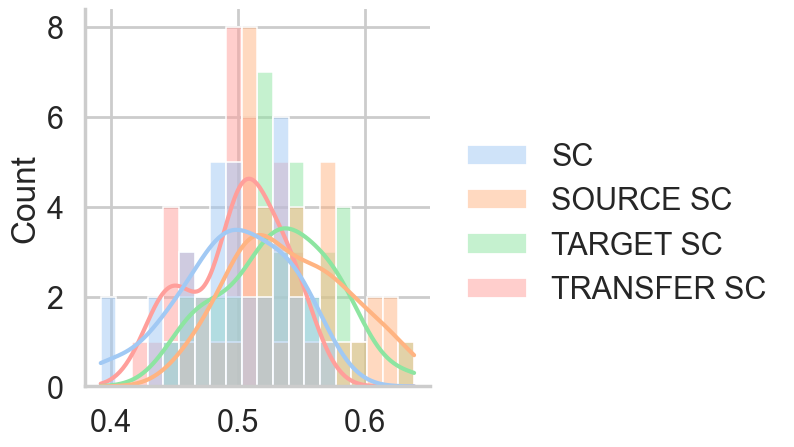

In [32]:
def overall_accs_report(weeks_to_train):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_acc_cat(A_test, Bs[week], test[week])[1])

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_acc_cat(A_test_target_only, Bs_only_target[week], test[week])[1])

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_acc_cat(A_test, Bs_tsc[week], test[week])[1])

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_acc_cat(A_test, Bs_only_target_from_target[week], test[week])[1])

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,
      'TRANSFER SC': tsc_res_list,
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(source_res_list), 3), round(np.mean(target_target_res_list), 3), round(np.mean(tsc_res_list), 3)

print(data_source)

sc, ssc, tarsc, tsc = overall_accs_report(weeks_to_train)
  

print('average DD accuracy on weeks for Mix SC', sc)
print('average DD accuracy on weeks for Source only SC, target only DD', ssc)
print('average DD accuracy on weeks for Target only SC and DD', tarsc)
print('average DD accuracy on weeks for Transfer SC', tsc)



average non-zero signal DD accuracy on weeks for Mix SC 0.701
average non-zero signal DD accuracy on weeks for Source only SC, target only DD 0.697
average non-zero signal DD accuracy on weeks for Target only SC and DD 0.703
average non-zero signal DD accuracy on weeks for Transfer SC 0.693


<Figure size 1500x1600 with 0 Axes>

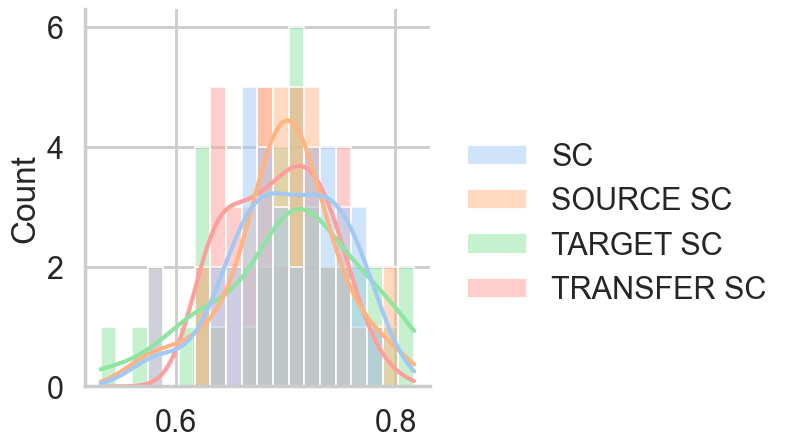

In [33]:
def overall_non_zero_accs_report(weeks_to_train):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_acc_cat_non_zero(A_test, Bs[week], test[week]))

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_acc_cat_non_zero(A_test_target_only, Bs_only_target[week], test[week]))

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_acc_cat_non_zero(A_test, Bs_tsc[week], test[week]))

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_acc_cat_non_zero(A_test, Bs_only_target_from_target[week], test[week]))

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,
      'TRANSFER SC': tsc_res_list,
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(source_res_list), 3), round(np.mean(target_target_res_list), 3), round(np.mean(tsc_res_list), 3)

print(data_source)

sc, ssc, tarsc, tsc = overall_non_zero_accs_report(weeks_to_train)
  

print('average non-zero signal DD accuracy on weeks for Mix SC', sc)
print('average non-zero signal DD accuracy on weeks for Source only SC, target only DD', ssc)
print('average non-zero signal DD accuracy on weeks for Target only SC and DD', tarsc)
print('average non-zero signal DD accuracy on weeks for Transfer SC', tsc)


##### Per category

In [34]:
def per_err_accs_report(weeks_to_train):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_error_per_category(A_test, Bs[week], test[week]))

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_error_per_category(A_test_target_only, Bs_only_target[week], test[week]))

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_error_per_category(A_test, Bs_tsc[week], test[week]))

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_error_per_category(A_test, Bs_only_target_from_target[week], test[week]))

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,
      'TRANSFER SC': tsc_res_list,
      }
      )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average Mix SC error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in source_res_list]
      print('average Source only SC, target only DD error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in source_res_list]), 3)))
      errors_target = [d[cat][0] for d in target_target_res_list]
      print('average Target only SC and DD error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in target_target_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tsc_res_list]
      print('average Transfer SC error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc

print(data_source)

sc_cat, ssc_cat, tarsc_cat, tsc_cat = per_err_accs_report(weeks_to_train)
  



average Mix SC error for fridge is 192.0 ratio is 0.087
average Source only SC, target only DD error for fridge is 170.0 ratio is 0.077
average Target only SC and DD error for fridge is 157.0 ratio is 0.073
average Transfer SC error for fridge is 181.0 ratio is 0.081


average Mix SC error for washing_drying is 250.0 ratio is 0.067
average Source only SC, target only DD error for washing_drying is 239.0 ratio is 0.064
average Target only SC and DD error for washing_drying is 244.0 ratio is 0.065
average Transfer SC error for washing_drying is 251.0 ratio is 0.068


average Mix SC error for computer_tv is 136.0 ratio is 0.072
average Source only SC, target only DD error for computer_tv is 163.0 ratio is 0.086
average Target only SC and DD error for computer_tv is 130.0 ratio is 0.069
average Transfer SC error for computer_tv is 147.0 ratio is 0.076


average Mix SC error for heating is 303.0 ratio is 0.053
average Source only SC, target only DD error for heating is 306.0 ratio is 0.053

In [66]:
def per_err_accs_report_non_zero(weeks_to_train):
  mix_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs[week],rp_gl=dsc.rp)
    mix_res_list.append(dd_error_per_category_non_zero(A_test, Bs[week], test[week]))

  source_res_list = []
  for week in range(weeks_to_train):
    A_test_target_only = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target[week],rp_gl=dsc.rp)
    source_res_list.append(dd_error_per_category_non_zero(A_test_target_only, Bs_only_target[week], test[week]))

  tsc_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_tsc[week],rp_gl=dsc.rp)
    tsc_res_list.append(dd_error_per_category_non_zero(A_test, Bs_tsc[week], test[week]))

  target_target_res_list = []
  for week in range(weeks_to_train):
    A_test = dsc.F_obj(x=test[week]['X_bar'].values, B=Bs_only_target_from_target[week],rp_gl=dsc.rp)
    target_target_res_list.append(dd_error_per_category_non_zero(A_test, Bs_only_target_from_target[week], test[week]))

  average_df = pd.DataFrame(
      {'SC': mix_res_list,
      'SOURCE SC': source_res_list,
      'TARGET SC': target_target_res_list,
      'TRANSFER SC': tsc_res_list,
      }
      )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average Mix SC non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in source_res_list]
      print('average Source only SC, target only DD non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in source_res_list]), 3)))
      errors_target = [d[cat][0] for d in target_target_res_list]
      print('average Target only SC and DD non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in target_target_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tsc_res_list]
      print('average Transfer SC non-zero error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc

print(data_source)

sc_cat, ssc_cat, tarsc_cat, tsc_cat = dd_error_per_category_non_zero(weeks_to_train)


# Plotting functions

In [35]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [36]:
method_dict = {
    'SC mix, DD mix': (As, Bs),
    'SC source, DD target': (As_only_target, Bs_only_target),
    'SC target, DD target': (As_only_target_from_target ,Bs_only_target_from_target),
    'Transfer SC+DD': (As_tsc, Bs_tsc),
}
colors = ['orange', 'green', 'purple', 'red']

In [40]:
nb_houses = test[0]['X_bar'].shape[1]
nb_houses

5

### Aggregate signal pred VS real plots

In [69]:
def get_all_agg_plots(data, nb_houses, nb_weeks, data_type='test'):
    figs, axes = [], []
    for week in range(nb_weeks):
        fig, ax = plt.subplots(figsize=(20, 20), nrows=nb_houses)
        plt.suptitle('Week {}'.format(week), fontsize=20)
        
        for house in range(nb_houses):
            xt = data[week]['X_bar']
            #for ind, cat in enumerate(all_categories):
            ax[house].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
            legend = []
            house_name = xt.columns[house]
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                legend.append(method)
                A_test = dsc.F_obj(x=data[week]['X_bar'].values, B=B[week],rp_gl=dsc.rp)
                abt = np.dot(B[week], A_test)
                ax[house].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
            ax[house].set_xlabel('Timestamp', fontsize=10)
            ax[house].set_ylabel('Consumption', fontsize=10)
            ax[house].set_title('DD for {} house {}, aggregate signal reconstruction'.format(data_type, house_name), fontsize=14)
            ax[house].legend(['real'] + legend)
        figs.append(fig)
        axes.append(ax)
        
    with PdfPages('plots/all_aggregate_plots_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)

            
            
def get_all_agg_plots_by_method(data, nb_houses, nb_weeks, data_type='test'):
    figs, axes = [], []
    for week in range(nb_weeks):        
        for house in range(nb_houses):
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            xt = data[week]['X_bar']
            house_name = xt.columns[house]
            plt.suptitle('Week {}, house {}'.format(week, house_name), fontsize=20)

            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                A_test = dsc.F_obj(x=data[week]['X_bar'].values, B=B[week],rp_gl=dsc.rp)
                abt = np.dot(B[week], A_test)
                ax[method_ind].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                ax[method_ind].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                ax[method_ind].set_xlabel('Timestamp', fontsize=24)
                ax[method_ind].set_ylabel('Consumption', fontsize=24)
                ax[method_ind].set_title('DD for {} house {}, method={}, aggregate signal reconstruction'.format(data_type, house_name, method), fontsize=26)
                ax[method_ind].legend(['real', 'predicted'])
            plt.tight_layout()
            figs.append(fig)
            axes.append(ax)
        
    with PdfPages('plots/all_aggregate_plots_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)


In [374]:
get_all_agg_plots(test, nb_houses, general_params['weeks_to_train'], data_type='test')

In [1]:
get_all_agg_plots_by_method(test, nb_houses, general_params['weeks_to_train'], data_type='test')

### Appliance signal pred VS real plots

In [72]:
def get_all_category_plots(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    for ind, cat in enumerate(appliance_categories):
        figs, axes = [], []
        for week in range(nb_weeks):
            fig, ax = plt.subplots(figsize=(20, 20), nrows=nb_houses)
            plt.suptitle('Week {}'.format(week), fontsize=20)

            for house in range(nb_houses):
                xt = test[week]['X'][appliance_categories[ind]]
                house_name = xt.columns[house]
                ax[house].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                legend = []
                for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                    B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]
                    A_test_app = dsc.F_obj(x=test[week]['X'][appliance_categories[ind]].values, B=B_test_app,rp_gl=general_params['rp'])
                    abt = np.dot(B_test_app, A_test_app)
                    
                    legend.append(method)
                    ax[house].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                ax[house].set_xlabel('Timestamp', fontsize=10)
                ax[house].set_ylabel('Consumption', fontsize=10)
                ax[house].set_title('DD for {} house {}, category={}'.format(data_type, house_name, cat), fontsize=14)
                ax[house].legend(['real'] + legend)
            figs.append(fig)
            axes.append(ax)

        with PdfPages('plots/all_{}_plots_{}_{}.pdf'.format(cat, data_type, data_source)) as pdf:
            for fig in figs:
                pdf.savefig(fig)

            
            
def get_all_category_plots_by_method(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    for ind, cat in enumerate(appliance_categories):
        figs, axes = [], []
        for week in range(nb_weeks):            
            for house in range(nb_houses):
                
                fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
                xt = test[week]['X'][appliance_categories[ind]]
                house_name = xt.columns[house]
                plt.suptitle('Week {}, house {}'.format(week, house_name), fontsize=20)

                for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                    
                    B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]

                    A_test_app = dsc.F_obj(x=test[week]['X'][cat].values, B=B_test_app,rp_gl=general_params['rp'])
                    abt = np.dot(B_test_app, A_test_app)                    
                    
                    ax[method_ind].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                    ax[method_ind].plot([i*100 for i in range(len(abt))], abt[:,house], c=colors[method_ind], alpha=0.5)
                    ax[method_ind].set_xlabel('Timestamp', fontsize=24)
                    ax[method_ind].set_ylabel('Consumption', fontsize=24)
                    ax[method_ind].set_title('DD for {} house {}, method={}, category={}'.format(data_type, house_name, method, cat), fontsize=26)
                    ax[method_ind].legend(['real', 'predicted'])
                plt.tight_layout()
                figs.append(fig)
                axes.append(ax)
        
        with PdfPages('plots/all_{}_plots_by_method_{}_{}.pdf'.format(cat, data_type, data_source)) as pdf:
            for fig in figs:
                pdf.savefig(fig)


In [73]:
#get_all_category_plots(test, nb_houses, general_params['weeks_to_train'], data_type='test')

In [2]:
get_all_category_plots_by_method(test, nb_houses, general_params['weeks_to_train'], data_type='test')

### Pie Chart of consumption

In [95]:
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

In [347]:
def get_consumption_pie_chart(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    figs, axes = [], []
    for week in range(nb_weeks):
        consumption_dict = defaultdict(dict)
        real_consumption_dict = defaultdict(dict)
        for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
            A = np.asarray(A)
            B = np.asarray(B)
            
            consumption_dict[method]['aggregate'] = data[week]['X_bar'].mean(axis=0).values
            real_consumption_dict[method]['aggregate'] = consumption_dict[method]['aggregate']
            for ind, cat in enumerate(appliance_categories):
                
                B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]

                A_test_app = dsc.F_obj(x=test[week]['X'][cat].values, B=B_test_app,rp_gl=general_params['rp'])
                abt = np.dot(B_test_app, A_test_app)                    

                #A_test = dsc.F_obj(x=data[week]['X_bar'].values, B=B[week],rp_gl=dsc.rp)
                #abt = np.dot(B[week], A_test)
                consumption_dict[method][cat] = abt.mean(axis=0)
                
                real_consumption_dict[method][cat] = data[week]['X'][cat].mean(axis=0).values
                
                
        for house in range(nb_houses):
            fig, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)
            house_name = data[week]['X'][cat].columns[house]
            plt.suptitle('Week {}, {} house {}'.format(week, data_type, house_name), fontsize=20)
            colors = ['#a1c9f4', '#ffb482', '#8ce5a1', '#ff9f9b', '#d1bbff']
            
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                # Predicted pie chart
                values = [consumption_dict[method][cat][house] for cat in appliance_categories]
                noise = consumption_dict[method]['aggregate'][house] - sum(values)
                if noise < 0:
                    noise = 0
                values.append(noise)
                ax[method_ind//2, method_ind%2].pie(values, labels=None, autopct='%1.1f%%', colors=colors)
                ax[method_ind//2, method_ind%2].set_title('Predicted, {}'.format(method), fontsize=24)

                
            fig_big, ax_big = plt.subplots(figsize=(8, 8))
            # Create the big subplot spanning two rows
            #big_plot_ax = fig.add_axes([1, 0.1, 0.5, 0.8])
            
            # Real pie chart
            real_values = [real_consumption_dict[method][cat][house] for cat in appliance_categories]
            real_noise = real_consumption_dict[method]['aggregate'][house] - sum(real_values)
            if real_noise < 0:
                real_noise = 0
            real_values.append(real_noise)
            ax_big.pie(real_values, labels=None, autopct='%1.1f%%', colors=colors)
            ax_big.set_title('Real', fontsize=24)
            
            divider = make_axes_locatable(ax_big)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            cmap = cm.colors.ListedColormap(colors)
            norm = cm.colors.Normalize(vmin=0, vmax=1)
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            cbar = fig.colorbar(sm, cax=cax)
            cbar.set_ticks([0.1, 0.3, 0.5, 0.7, 0.9])
            cbar.set_ticklabels(appliance_categories + ['noise'])
            
            plt.tight_layout()
            #fig.delaxes(ax[0, 2])
            #fig.delaxes(ax[1, 2])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            figs.append(fig)
            axes.append(ax)

    with PdfPages('plots/pie_charts_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)
            pdf.savefig(fig_big)


In [ ]:
get_consumption_pie_chart(test, nb_houses, general_params['weeks_to_train'], data_type='test')

### Basis functions

In [271]:
def plot_bases(data, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    figs, axes = [], []
    for ind, cat in enumerate(appliance_categories):
        for week in range(nb_weeks):            
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            plt.suptitle('Week {}'.format(week), fontsize=20)
            xt = test[week]['X'][appliance_categories[ind]]
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):

                B_test_app = B[week][:,ind*n_components:(ind+1)*n_components].T

                ax[method_ind].imshow(B_test_app, cmap='gray')
                ax[method_ind].set_title('Learned Basis functions, method={}, category={}'.format(method, cat), fontsize=14)
            figs.append(fig)
            axes.append(ax)
        
        with PdfPages('plots/basis_functions_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
            for fig in figs:
                pdf.savefig(fig)

In [280]:
plot_bases(test, general_params['weeks_to_train'], data_type='test')

### Noise signal pred VS real plots

In [78]:
def get_noise(data, nb_houses, nb_weeks, data_type='test'):
    n_components = nnsc_params['n_components']
    figs, axes = [], []
    for week in range(nb_weeks):
        pred_noise = dict()
        real_noise = dict()
        for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
            A = np.asarray(A)
            B = np.asarray(B)

            pred_noise[method] = data[week]['X_bar'].values
            real_noise[method] = data[week]['X_bar'].values
            for ind, cat in enumerate(appliance_categories):
                B_test_app = B[week][:,ind*n_components:(ind+1)*n_components]
                A_test_app = dsc.F_obj(x=test[week]['X'][cat].values, B=B_test_app,rp_gl=general_params['rp'])
                abt = np.dot(B_test_app, A_test_app)   
                pred_noise[method] = pred_noise[method] - abt
                real_noise[method] = real_noise[method] - data[week]['X'][cat].values
                
        for house in range(nb_houses):
            house_name = data[week]['X_bar'].columns[house]
            fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
            plt.suptitle('Week {}, {} house {}'.format(week, data_type, house_name), fontsize=20)
            for method_ind, (method, (A, B)) in enumerate(method_dict.items()):
                
                
                ax[method_ind].plot([i*100 for i in range(len(real_noise[method]))], real_noise[method][:,house], c='blue', alpha=0.5)
                ax[method_ind].plot([i*100 for i in range(len(real_noise[method]))], pred_noise[method][:,house], c=colors[ind], alpha=0.5)
                ax[method_ind].set_xlabel('Timestamp', fontsize=24)
                ax[method_ind].set_ylabel('Consumption', fontsize=24)
                ax[method_ind].set_title('DD noise for {} house {}, method={}'.format(data_type, house_name, method), fontsize=26)
                ax[method_ind].legend(['real', 'predicted'])
            plt.tight_layout()
            figs.append(fig)
            axes.append(ax)

    with PdfPages('plots/noise_by_method_{}_{}.pdf'.format(data_type, data_source)) as pdf:
        for fig in figs:
            pdf.savefig(fig)



In [3]:
get_noise(test, nb_houses, general_params['weeks_to_train'], data_type='test')